In [1]:
import os
import random
import time
import datetime
import copy
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import KFold

import torch
from torch import nn, optim

from torchvision import transforms, models, datasets

import splitfolders

In [2]:
def initialize_model(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(weights='DEFAULT')
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(weights='DEFAULT')
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(weights='DEFAULT')
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(weights='DEFAULT')
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(weights='DEFAULT')
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(weights='DEFAULT')
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [3]:
def evaluate_model(model, dataloader, device):
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true += labels.tolist()
            y_pred += predicted.tolist()

    return y_true, y_pred

In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, model_name, fold, save_dir):
    """
    Plota gráfico de loss e accuracy por epoch para conjunto de treinamento e validação
    
    Args:
        train_losses (list): Lista com os valores de loss do conjunto de treinamento por epoch
        val_losses (list): Lista com os valores de loss do conjunto de validação por epoch
        train_accs (list): Lista com os valores de accuracy do conjunto de treinamento por epoch
        val_accs (list): Lista com os valores de accuracy do conjunto de validação por epoch
    
    Returns:
        None
    """
    # Define o número de epochs
    epochs = len(train_losses)
    
    # Define o eixo x do gráfico como o número de epochs
    x = range(1, epochs + 1)
    
    # Plota os gráficos de loss e accuracy para conjunto de treinamento e validação
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_losses, c='magenta' ,ls='--', label='Train loss', fillstyle='none')
    plt.plot(x, val_losses, c='green' ,ls='--', label='Val. loss', fillstyle='none')
    plt.title('Loss por epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, [acc.cpu() for acc in train_accs], c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
    plt.plot(x, [acc.cpu() for acc in val_accs], c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
    plt.title('Accuracy por epoch')
    plt.legend()
    
    plt.savefig(f'{save_dir}/{model_name}_fold_{fold}_loss_acc.pdf')
    plt.show()

In [6]:
def generate_classification_report(model, dataloader,class_names, device='cpu'):
    # Define o modelo para o dispositivo correto (CPU ou GPU)
    model = model.to(device)
    model.eval()
    
    # Inicializa as variáveis de predições e rótulos verdadeiros
    all_preds = torch.tensor([], dtype=torch.long, device=device)
    all_labels = torch.tensor([], dtype=torch.long, device=device)

    # Realiza a predição para cada lote de dados no dataloader
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Adiciona as predições e rótulos verdadeiros às variáveis criadas anteriormente
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Gera o classification report com base nas predições e rótulos verdadeiros
    report = metrics.classification_report(all_labels.cpu().numpy(), all_preds.cpu().numpy(),target_names=class_names,
                                           digits=4, zero_division=0)
    
    return report

In [7]:
def train_model(model, dataloaders, optimizer, basic_parameters, fold, date_now, device='cpu'):
    
    # Tempo total do treinamento (treinamento e validação)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    model_name = basic_parameters.get('model_name')
    num_epochs = basic_parameters.get('epochs')
    batch_size = basic_parameters.get('batch_size')

    # Cria a pasta com o nome do modelo
    output_dir = r'outputs/' + model_name
    os.makedirs(output_dir, exist_ok=True)

    # Cria a pasta para separar os testes
    result_dir = output_dir + '\\' + model_name +'_' + date_now
    os.makedirs(result_dir, exist_ok=True)

    # Abre o arquivo para salvar o resultado
    f = open(f'{result_dir}/{model_name}_fold_{fold}.txt', 'w')
    
    for epoch in range(num_epochs):
        f.write(f'Epoch {epoch}/{num_epochs - 1}\n')
        f.write('-' * 10 + '\n')

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            # Inicia contagem de tempo da época
            time_epoch_start = time.time()

            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Perda (loss) nesta época
            running_loss = 0.0
            # Amostras classificadas corretamente nesta época
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if model_name == 'inception' and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = basic_parameters.get('criterion')(outputs, labels)
                        loss2 = basic_parameters.get('criterion')(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = basic_parameters.get('criterion')(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Atualiza a perda da época
                running_loss += loss.item() * inputs.size(0)
                # Atualiza o número de amostras classificadas corretamente na época.
                running_corrects += torch.sum(preds == labels.data)
            # Perda desta época
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # Acurácia desta época
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Tempo total desta época
            time_epoch = time.time() - time_epoch_start

            f.write(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({time_epoch:.4f} seconds) \n')

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({time_epoch:.4f} seconds)')

            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_epoch = time.time() - since

        f.write(f'Time: {time_epoch:.0f}s\n')
        f.write('\n')

        print(f'Time: {time_epoch:.0f}s')
        print('\n')

    time_elapsed = time.time() - since
    f.write(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n')
    f.write(f'Number of epochs: {num_epochs}. Batch size: {batch_size}\n')
    f.write(f'Best val loss: {best_loss:.4f} Best val acc: {best_acc:.4f}\n')

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f} Best val acc: {best_acc:.4f}')

    # Save the confusion matrix
    y_true, y_pred = evaluate_model(model, dataloaders['val'], device=device)
    # Confusion matrix
    conf_mat_val = metrics.confusion_matrix(y_true, y_pred)
    f.write(f'\nConfusion Matrix:\n{conf_mat_val}\n')

    # print(f'Confusion Matrix:\n{conf_mat_val}')

    # Classification report 
    class_rep_val = generate_classification_report(model, dataloaders['val'],basic_parameters.get('class_names'), device)    
    f.write(f'\nClassification report:\n{class_rep_val}\n')


    f.close()

    # Save the plot
    plt.figure()
    plot_confusion_matrix(conf_mat_val, classes=basic_parameters.get('class_names'))
    plt.savefig(f'{result_dir}/{model_name}_fold_{fold}_cf_mat.pdf')

    #Plota gráfico de loss e accuracy por epoch
    plot_loss_accuracy(train_loss_list, val_loss_list, train_acc_list, val_acc_list, model_name, fold, result_dir)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

FOLD 0, Model: resnet
Epoch 0/49
----------
Train Loss: 0.5199 Acc: 0.7404 (21.5320 seconds)
Val Loss: 0.4125 Acc: 0.8045 (10.2047 seconds)
Time: 32s


Epoch 1/49
----------
Train Loss: 0.3429 Acc: 0.8462 (19.9834 seconds)
Val Loss: 0.2378 Acc: 0.8974 (10.2603 seconds)
Time: 63s


Epoch 2/49
----------
Train Loss: 0.2876 Acc: 0.8846 (19.8581 seconds)
Val Loss: 0.2491 Acc: 0.9038 (10.2209 seconds)
Time: 93s


Epoch 3/49
----------
Train Loss: 0.2634 Acc: 0.9014 (20.2785 seconds)
Val Loss: 0.2348 Acc: 0.9135 (10.9189 seconds)
Time: 124s


Epoch 4/49
----------
Train Loss: 0.2536 Acc: 0.9038 (20.2915 seconds)
Val Loss: 0.2628 Acc: 0.9071 (10.2573 seconds)
Time: 155s


Epoch 5/49
----------
Train Loss: 0.2436 Acc: 0.8998 (20.3536 seconds)
Val Loss: 0.2211 Acc: 0.9199 (10.1432 seconds)
Time: 185s


Epoch 6/49
----------
Train Loss: 0.2480 Acc: 0.9046 (20.2100 seconds)
Val Loss: 0.2426 Acc: 0.9295 (10.2383 seconds)
Time: 216s


Epoch 7/49
----------
Train Loss: 0.2347 Acc: 0.8982 (19.9610 se

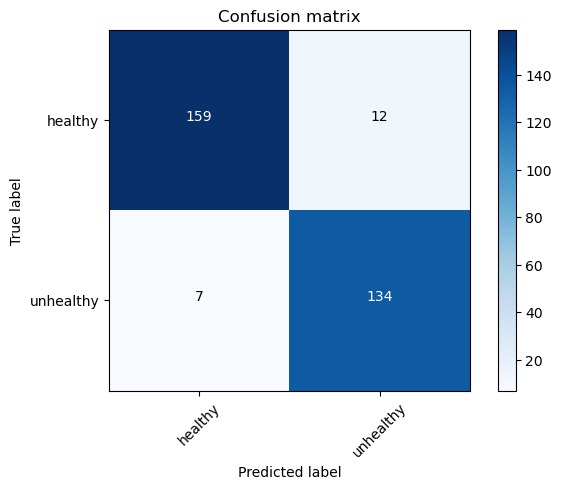

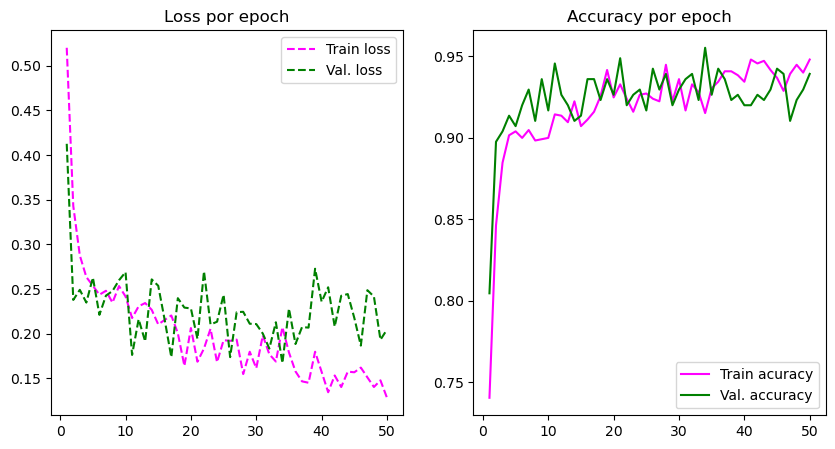

FOLD 1, Model: resnet
Epoch 0/49
----------
Train Loss: 0.5717 Acc: 0.6883 (20.2175 seconds)
Val Loss: 0.4037 Acc: 0.8109 (11.0591 seconds)
Time: 31s


Epoch 1/49
----------
Train Loss: 0.3969 Acc: 0.8245 (19.9962 seconds)
Val Loss: 0.3632 Acc: 0.8718 (10.8018 seconds)
Time: 62s


Epoch 2/49
----------
Train Loss: 0.3009 Acc: 0.8630 (20.9401 seconds)
Val Loss: 0.3109 Acc: 0.8750 (10.4795 seconds)
Time: 94s


Epoch 3/49
----------
Train Loss: 0.2713 Acc: 0.8974 (20.2947 seconds)
Val Loss: 0.2677 Acc: 0.8910 (11.0000 seconds)
Time: 125s


Epoch 4/49
----------
Train Loss: 0.2560 Acc: 0.8998 (19.9825 seconds)
Val Loss: 0.3030 Acc: 0.8686 (10.7608 seconds)
Time: 156s


Epoch 5/49
----------
Train Loss: 0.2583 Acc: 0.9022 (19.4868 seconds)
Val Loss: 0.3236 Acc: 0.8718 (10.5816 seconds)
Time: 186s


Epoch 6/49
----------
Train Loss: 0.2431 Acc: 0.8982 (19.6839 seconds)
Val Loss: 0.3247 Acc: 0.8878 (10.3494 seconds)
Time: 216s


Epoch 7/49
----------
Train Loss: 0.2490 Acc: 0.9071 (19.6184 se

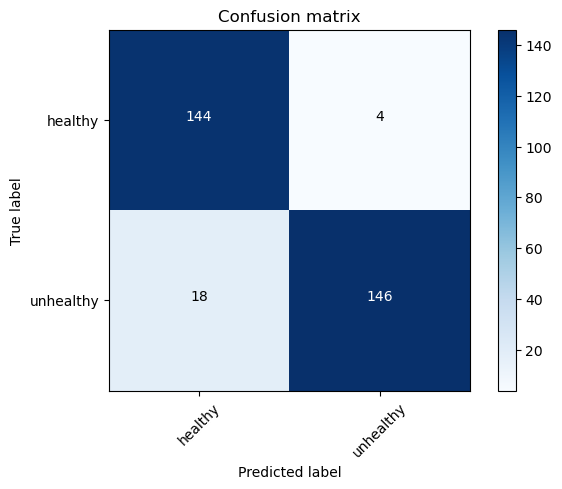

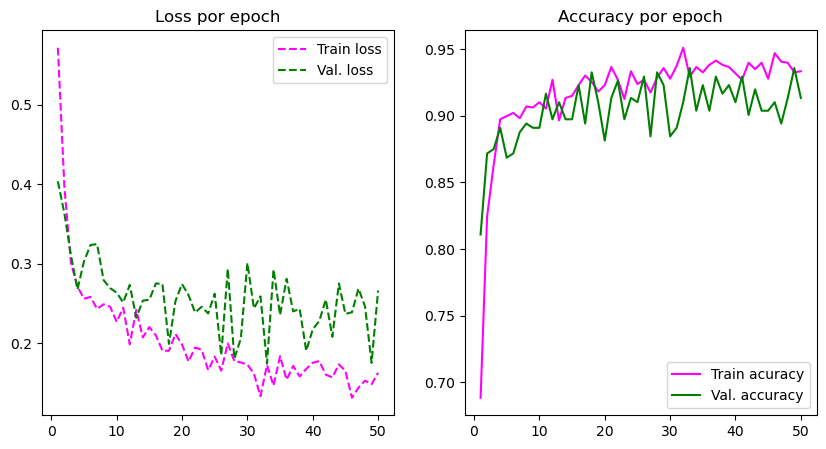

FOLD 2, Model: resnet
Epoch 0/49
----------
Train Loss: 0.5467 Acc: 0.7171 (20.1263 seconds)
Val Loss: 0.4317 Acc: 0.8045 (10.2684 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.3685 Acc: 0.8438 (20.4716 seconds)
Val Loss: 0.3255 Acc: 0.8718 (10.4145 seconds)
Time: 61s


Epoch 2/49
----------
Train Loss: 0.3231 Acc: 0.8630 (20.3781 seconds)
Val Loss: 0.2860 Acc: 0.8974 (9.9770 seconds)
Time: 92s


Epoch 3/49
----------
Train Loss: 0.2791 Acc: 0.8862 (19.6241 seconds)
Val Loss: 0.2959 Acc: 0.8910 (10.0999 seconds)
Time: 121s


Epoch 4/49
----------
Train Loss: 0.2890 Acc: 0.8878 (20.0256 seconds)
Val Loss: 0.3312 Acc: 0.8782 (10.0218 seconds)
Time: 151s


Epoch 5/49
----------
Train Loss: 0.2399 Acc: 0.9030 (19.2211 seconds)
Val Loss: 0.2465 Acc: 0.9006 (9.9082 seconds)
Time: 181s


Epoch 6/49
----------
Train Loss: 0.2225 Acc: 0.9143 (20.3195 seconds)
Val Loss: 0.2482 Acc: 0.9135 (9.9849 seconds)
Time: 211s


Epoch 7/49
----------
Train Loss: 0.2293 Acc: 0.9103 (19.7283 secon

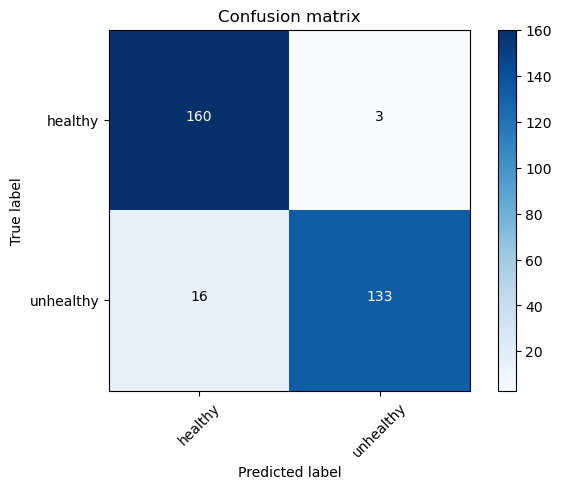

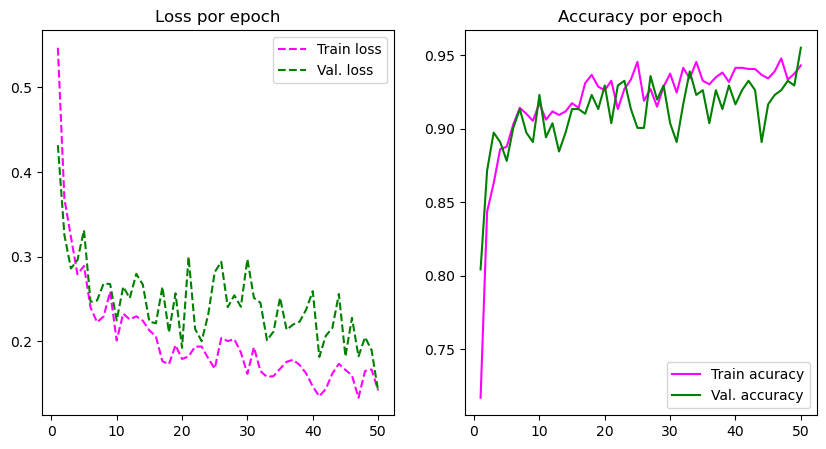

FOLD 3, Model: resnet
Epoch 0/49
----------
Train Loss: 0.5521 Acc: 0.7107 (19.9011 seconds)
Val Loss: 0.4013 Acc: 0.8269 (10.0279 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.3491 Acc: 0.8518 (19.6805 seconds)
Val Loss: 0.3288 Acc: 0.8526 (9.8821 seconds)
Time: 60s


Epoch 2/49
----------
Train Loss: 0.2885 Acc: 0.8814 (19.9323 seconds)
Val Loss: 0.2686 Acc: 0.8942 (9.9784 seconds)
Time: 89s


Epoch 3/49
----------
Train Loss: 0.2796 Acc: 0.8926 (19.6530 seconds)
Val Loss: 0.2367 Acc: 0.9038 (10.0005 seconds)
Time: 119s


Epoch 4/49
----------
Train Loss: 0.3094 Acc: 0.8702 (19.6312 seconds)
Val Loss: 0.2477 Acc: 0.9038 (10.1296 seconds)
Time: 149s


Epoch 5/49
----------
Train Loss: 0.2571 Acc: 0.9014 (19.5485 seconds)
Val Loss: 0.2738 Acc: 0.9038 (9.7290 seconds)
Time: 178s


Epoch 6/49
----------
Train Loss: 0.2263 Acc: 0.9062 (19.5106 seconds)
Val Loss: 0.3243 Acc: 0.8654 (10.0923 seconds)
Time: 208s


Epoch 7/49
----------
Train Loss: 0.2327 Acc: 0.9079 (20.4671 secon

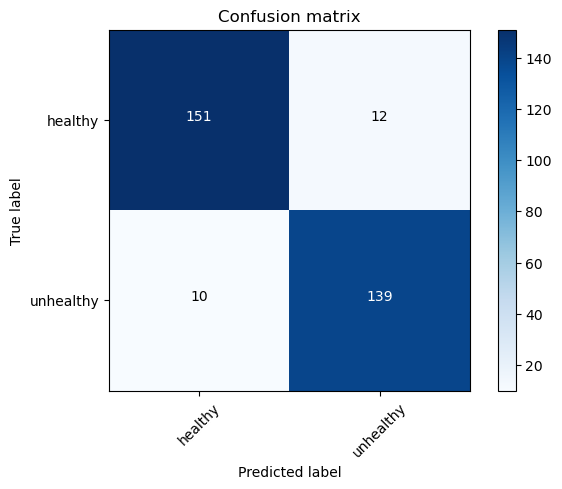

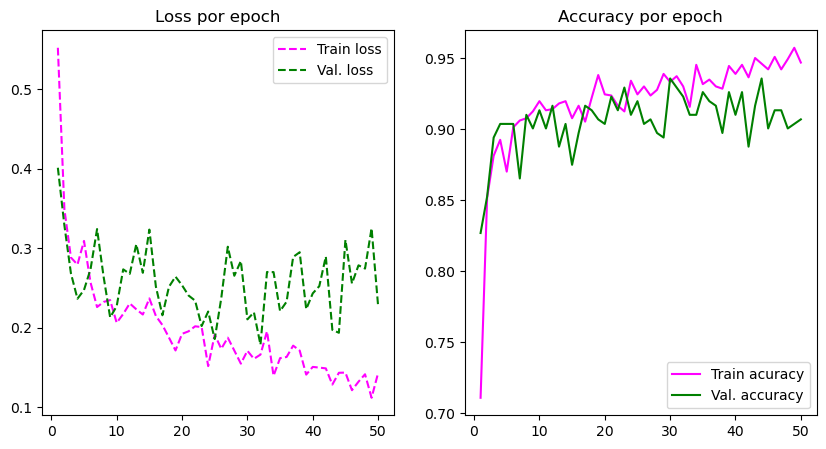

FOLD 4, Model: resnet
Epoch 0/49
----------
Train Loss: 0.5590 Acc: 0.6979 (19.6525 seconds)
Val Loss: 0.3962 Acc: 0.8269 (10.0319 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.3647 Acc: 0.8397 (19.9462 seconds)
Val Loss: 0.2441 Acc: 0.9071 (10.5369 seconds)
Time: 60s


Epoch 2/49
----------
Train Loss: 0.3097 Acc: 0.8678 (19.8633 seconds)
Val Loss: 0.2583 Acc: 0.8974 (9.8908 seconds)
Time: 90s


Epoch 3/49
----------
Train Loss: 0.2923 Acc: 0.8886 (20.0369 seconds)
Val Loss: 0.1846 Acc: 0.9263 (10.4979 seconds)
Time: 120s


Epoch 4/49
----------
Train Loss: 0.2412 Acc: 0.9038 (20.0143 seconds)
Val Loss: 0.1812 Acc: 0.9263 (10.0805 seconds)
Time: 151s


Epoch 5/49
----------
Train Loss: 0.2615 Acc: 0.8990 (19.4296 seconds)
Val Loss: 0.1759 Acc: 0.9231 (10.0182 seconds)
Time: 180s


Epoch 6/49
----------
Train Loss: 0.2586 Acc: 0.8894 (20.2831 seconds)
Val Loss: 0.2467 Acc: 0.9103 (9.8866 seconds)
Time: 210s


Epoch 7/49
----------
Train Loss: 0.2448 Acc: 0.8990 (19.6802 seco

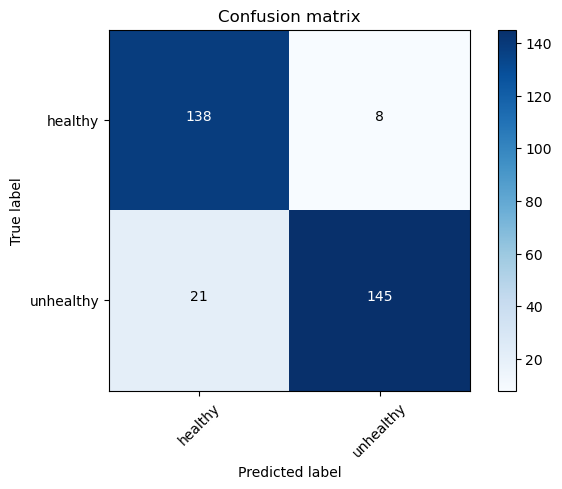

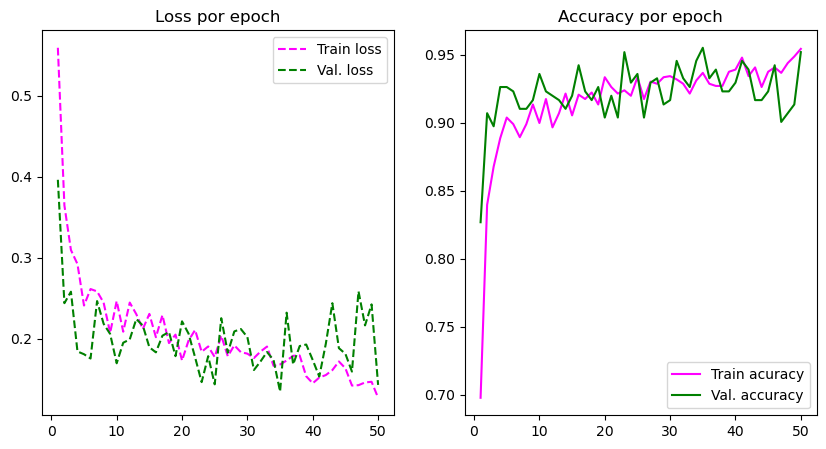

FOLD 0, Model: alexnet
Epoch 0/49
----------
Train Loss: 0.5808 Acc: 0.6923 (19.8214 seconds)
Val Loss: 0.5555 Acc: 0.7179 (10.3805 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.5308 Acc: 0.7380 (19.4448 seconds)
Val Loss: 0.4387 Acc: 0.8045 (10.2948 seconds)
Time: 60s


Epoch 2/49
----------
Train Loss: 0.4101 Acc: 0.8133 (19.6273 seconds)
Val Loss: 0.3746 Acc: 0.8397 (10.0187 seconds)
Time: 90s


Epoch 3/49
----------
Train Loss: 0.3949 Acc: 0.8269 (19.8259 seconds)
Val Loss: 0.3236 Acc: 0.8526 (10.2154 seconds)
Time: 120s


Epoch 4/49
----------
Train Loss: 0.3430 Acc: 0.8534 (19.4212 seconds)
Val Loss: 0.3887 Acc: 0.8654 (10.3887 seconds)
Time: 149s


Epoch 5/49
----------
Train Loss: 0.3412 Acc: 0.8502 (19.6652 seconds)
Val Loss: 0.3992 Acc: 0.8141 (10.3294 seconds)
Time: 179s


Epoch 6/49
----------
Train Loss: 0.3114 Acc: 0.8654 (19.4826 seconds)
Val Loss: 0.3282 Acc: 0.8878 (9.9194 seconds)
Time: 209s


Epoch 7/49
----------
Train Loss: 0.3349 Acc: 0.8566 (19.4003 se

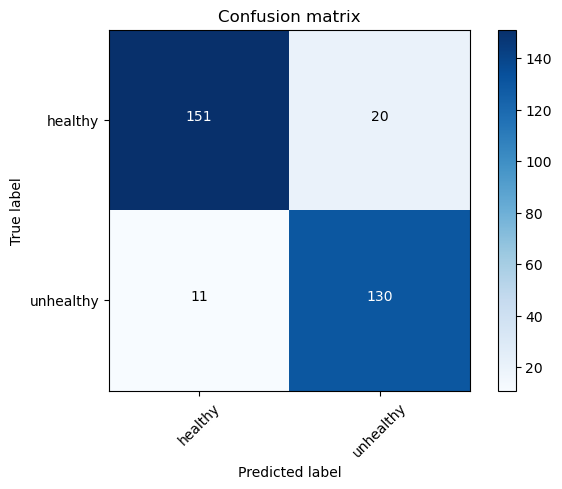

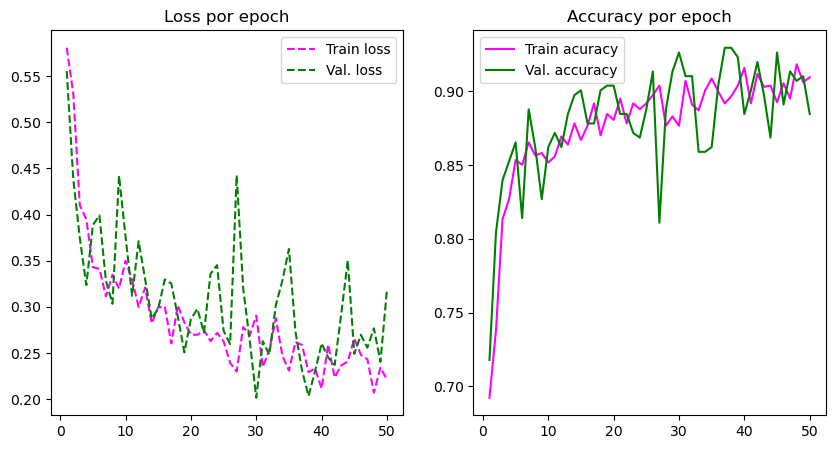

FOLD 1, Model: alexnet
Epoch 0/49
----------
Train Loss: 0.6507 Acc: 0.6378 (19.3081 seconds)
Val Loss: 0.5406 Acc: 0.7212 (10.3867 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.4871 Acc: 0.7724 (19.2639 seconds)
Val Loss: 0.3892 Acc: 0.8301 (10.6125 seconds)
Time: 60s


Epoch 2/49
----------
Train Loss: 0.3983 Acc: 0.8181 (19.1757 seconds)
Val Loss: 0.3757 Acc: 0.8109 (10.9449 seconds)
Time: 90s


Epoch 3/49
----------
Train Loss: 0.4099 Acc: 0.8173 (19.1249 seconds)
Val Loss: 0.4329 Acc: 0.7853 (10.3313 seconds)
Time: 119s


Epoch 4/49
----------
Train Loss: 0.3611 Acc: 0.8397 (19.4043 seconds)
Val Loss: 0.3553 Acc: 0.8301 (10.3607 seconds)
Time: 149s


Epoch 5/49
----------
Train Loss: 0.3431 Acc: 0.8582 (19.7427 seconds)
Val Loss: 0.4624 Acc: 0.7949 (10.3656 seconds)
Time: 179s


Epoch 6/49
----------
Train Loss: 0.3349 Acc: 0.8606 (19.2828 seconds)
Val Loss: 0.3742 Acc: 0.8397 (10.6766 seconds)
Time: 209s


Epoch 7/49
----------
Train Loss: 0.3328 Acc: 0.8614 (19.3491 s

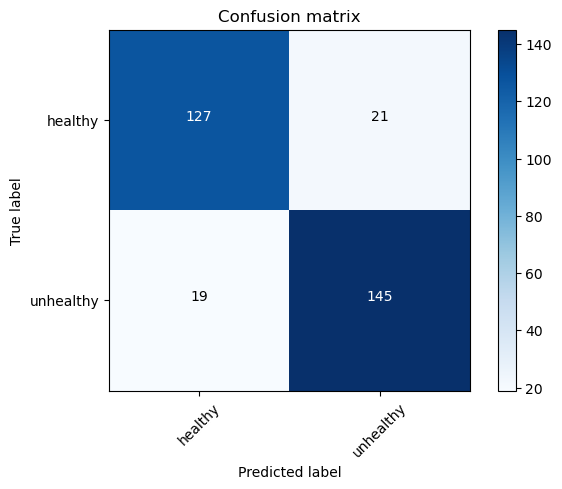

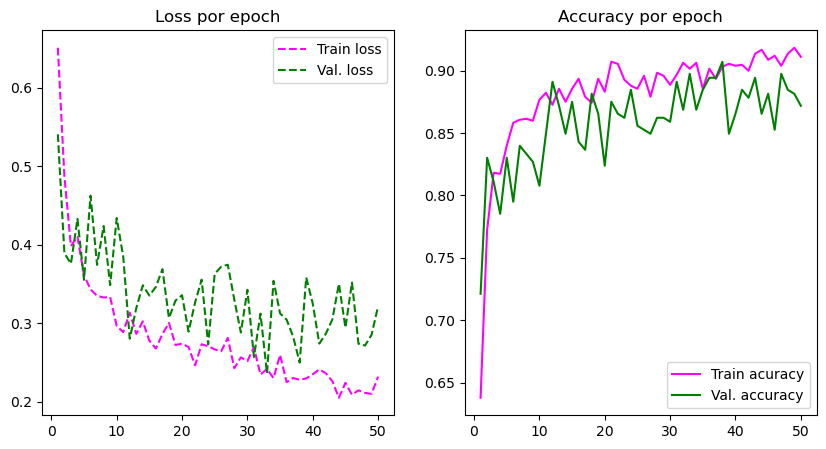

FOLD 2, Model: alexnet
Epoch 0/49
----------
Train Loss: 0.6887 Acc: 0.6210 (20.3222 seconds)
Val Loss: 0.5498 Acc: 0.6827 (9.9752 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.4618 Acc: 0.7796 (19.3146 seconds)
Val Loss: 0.4550 Acc: 0.7788 (10.0924 seconds)
Time: 60s


Epoch 2/49
----------
Train Loss: 0.4304 Acc: 0.7925 (19.5857 seconds)
Val Loss: 0.3759 Acc: 0.8429 (9.8956 seconds)
Time: 89s


Epoch 3/49
----------
Train Loss: 0.3753 Acc: 0.8454 (19.7828 seconds)
Val Loss: 0.3574 Acc: 0.8462 (9.7266 seconds)
Time: 119s


Epoch 4/49
----------
Train Loss: 0.3811 Acc: 0.8389 (19.4847 seconds)
Val Loss: 0.3904 Acc: 0.8558 (9.6866 seconds)
Time: 148s


Epoch 5/49
----------
Train Loss: 0.3691 Acc: 0.8405 (19.8633 seconds)
Val Loss: 0.3134 Acc: 0.8654 (9.8771 seconds)
Time: 178s


Epoch 6/49
----------
Train Loss: 0.3184 Acc: 0.8662 (20.0376 seconds)
Val Loss: 0.4117 Acc: 0.8237 (9.9110 seconds)
Time: 208s


Epoch 7/49
----------
Train Loss: 0.3595 Acc: 0.8550 (20.1249 seconds

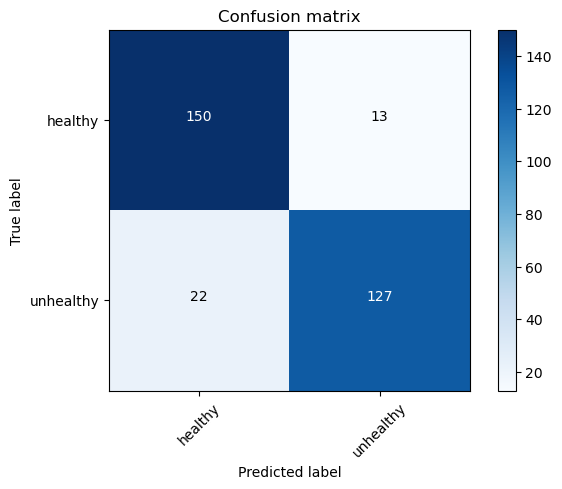

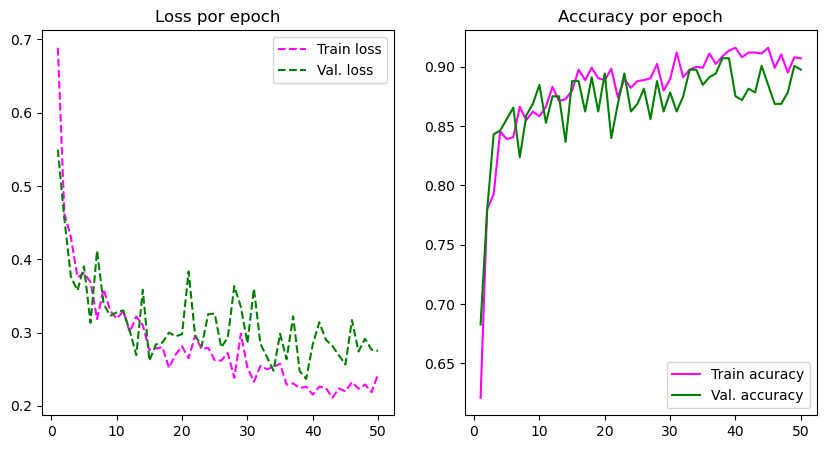

FOLD 3, Model: alexnet
Epoch 0/49
----------
Train Loss: 0.6318 Acc: 0.6434 (19.4509 seconds)
Val Loss: 0.5191 Acc: 0.7500 (9.4580 seconds)
Time: 29s


Epoch 1/49
----------
Train Loss: 0.4584 Acc: 0.7764 (19.4483 seconds)
Val Loss: 0.4156 Acc: 0.8109 (9.8122 seconds)
Time: 58s


Epoch 2/49
----------
Train Loss: 0.4253 Acc: 0.8133 (19.8708 seconds)
Val Loss: 0.4328 Acc: 0.7981 (9.4681 seconds)
Time: 88s


Epoch 3/49
----------
Train Loss: 0.3863 Acc: 0.8261 (19.5316 seconds)
Val Loss: 0.3580 Acc: 0.8365 (9.6269 seconds)
Time: 117s


Epoch 4/49
----------
Train Loss: 0.3599 Acc: 0.8478 (19.9290 seconds)
Val Loss: 0.3903 Acc: 0.8494 (9.8199 seconds)
Time: 146s


Epoch 5/49
----------
Train Loss: 0.3395 Acc: 0.8510 (19.7926 seconds)
Val Loss: 0.3890 Acc: 0.8173 (10.2059 seconds)
Time: 176s


Epoch 6/49
----------
Train Loss: 0.3376 Acc: 0.8486 (20.1581 seconds)
Val Loss: 0.3427 Acc: 0.8494 (9.7910 seconds)
Time: 206s


Epoch 7/49
----------
Train Loss: 0.3294 Acc: 0.8606 (19.7613 seconds

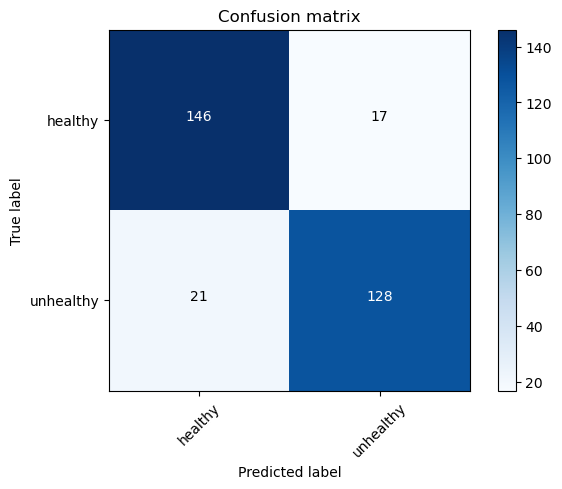

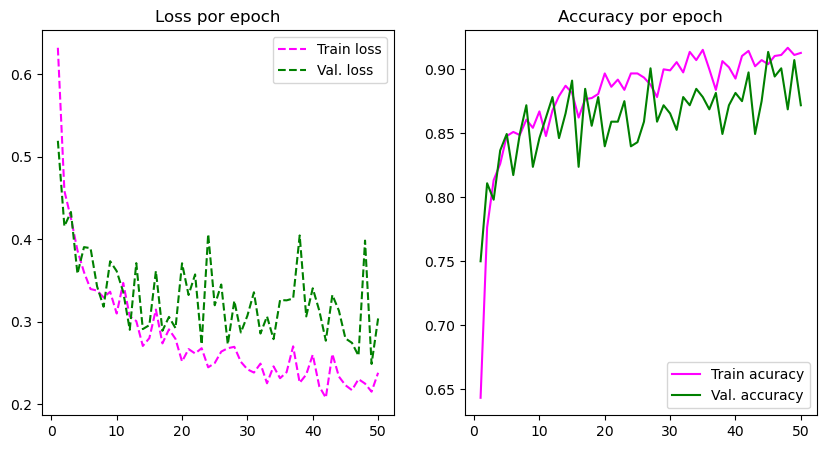

FOLD 4, Model: alexnet
Epoch 0/49
----------
Train Loss: 0.6827 Acc: 0.6226 (19.5125 seconds)
Val Loss: 0.5639 Acc: 0.6538 (9.8948 seconds)
Time: 29s


Epoch 1/49
----------
Train Loss: 0.5029 Acc: 0.7628 (19.7030 seconds)
Val Loss: 0.3941 Acc: 0.7981 (9.7440 seconds)
Time: 59s


Epoch 2/49
----------
Train Loss: 0.4523 Acc: 0.7845 (19.8226 seconds)
Val Loss: 0.3159 Acc: 0.8590 (9.6991 seconds)
Time: 88s


Epoch 3/49
----------
Train Loss: 0.3993 Acc: 0.8221 (19.7259 seconds)
Val Loss: 0.3215 Acc: 0.8750 (9.7805 seconds)
Time: 118s


Epoch 4/49
----------
Train Loss: 0.3801 Acc: 0.8261 (19.7067 seconds)
Val Loss: 0.3619 Acc: 0.8494 (9.8794 seconds)
Time: 147s


Epoch 5/49
----------
Train Loss: 0.3792 Acc: 0.8429 (20.0314 seconds)
Val Loss: 0.3783 Acc: 0.8173 (9.9571 seconds)
Time: 177s


Epoch 6/49
----------
Train Loss: 0.3729 Acc: 0.8317 (20.1578 seconds)
Val Loss: 0.3156 Acc: 0.8397 (9.6837 seconds)
Time: 207s


Epoch 7/49
----------
Train Loss: 0.3259 Acc: 0.8646 (19.8691 seconds)

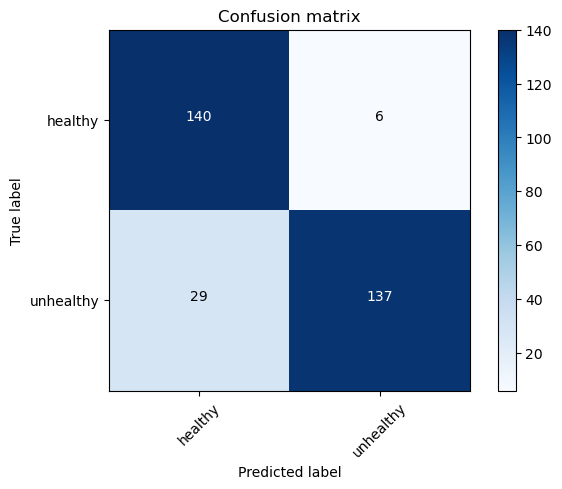

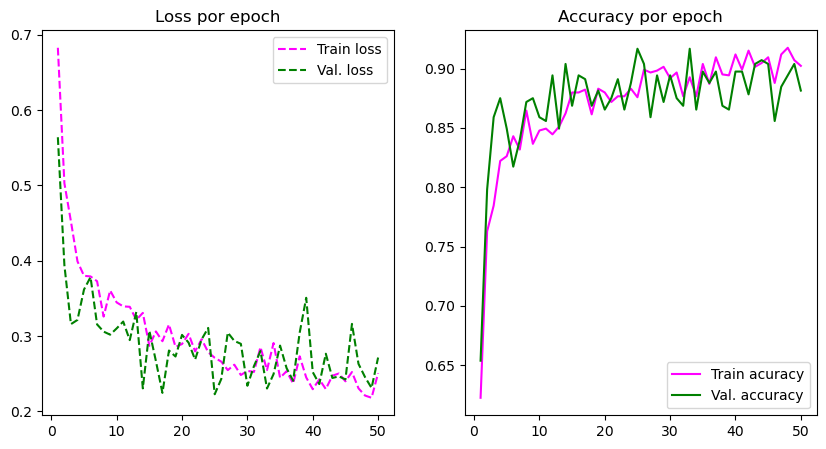

FOLD 0, Model: vgg
Epoch 0/49
----------
Train Loss: 0.5554 Acc: 0.7051 (22.2901 seconds)
Val Loss: 0.3486 Acc: 0.8429 (11.0390 seconds)
Time: 33s


Epoch 1/49
----------
Train Loss: 0.3753 Acc: 0.8293 (20.0148 seconds)
Val Loss: 0.2887 Acc: 0.8846 (10.2682 seconds)
Time: 64s


Epoch 2/49
----------
Train Loss: 0.2983 Acc: 0.8710 (19.8484 seconds)
Val Loss: 0.2676 Acc: 0.8910 (9.9670 seconds)
Time: 93s


Epoch 3/49
----------
Train Loss: 0.2946 Acc: 0.8878 (20.1329 seconds)
Val Loss: 0.2355 Acc: 0.9103 (10.4584 seconds)
Time: 124s


Epoch 4/49
----------
Train Loss: 0.2447 Acc: 0.8998 (19.8886 seconds)
Val Loss: 0.2137 Acc: 0.9359 (10.3069 seconds)
Time: 154s


Epoch 5/49
----------
Train Loss: 0.2431 Acc: 0.9014 (19.4919 seconds)
Val Loss: 0.1828 Acc: 0.9359 (10.3041 seconds)
Time: 184s


Epoch 6/49
----------
Train Loss: 0.2529 Acc: 0.8990 (20.2635 seconds)
Val Loss: 0.2050 Acc: 0.9327 (9.8928 seconds)
Time: 214s


Epoch 7/49
----------
Train Loss: 0.2161 Acc: 0.9135 (20.3055 seconds

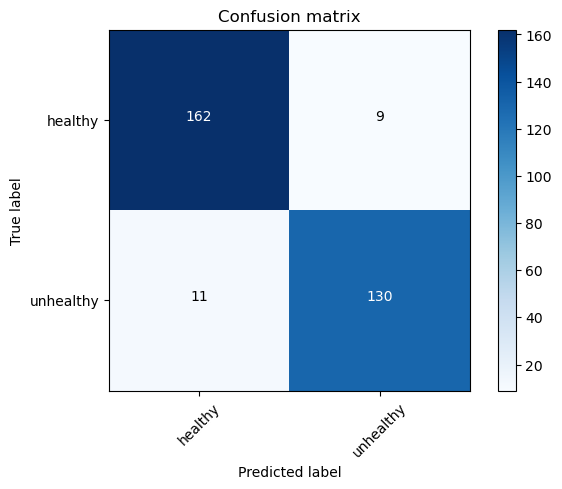

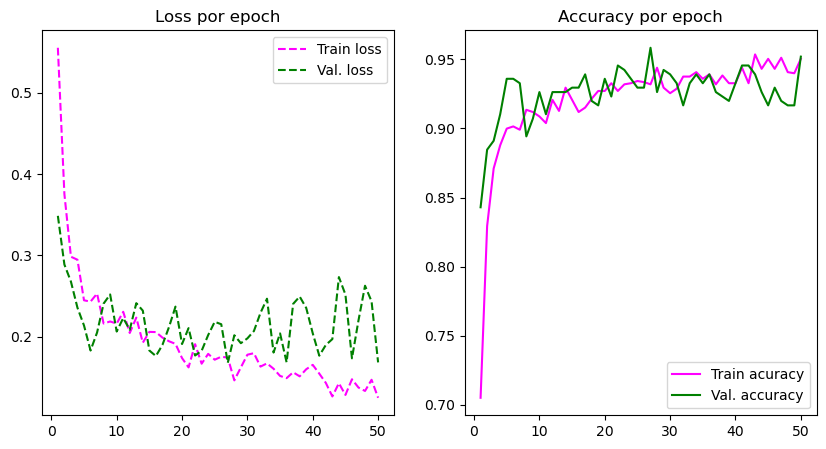

FOLD 1, Model: vgg
Epoch 0/49
----------
Train Loss: 0.5368 Acc: 0.7252 (19.7453 seconds)
Val Loss: 0.3822 Acc: 0.8301 (10.7177 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.3295 Acc: 0.8558 (19.7290 seconds)
Val Loss: 0.2990 Acc: 0.8782 (11.1079 seconds)
Time: 61s


Epoch 2/49
----------
Train Loss: 0.2875 Acc: 0.8846 (19.0633 seconds)
Val Loss: 0.2827 Acc: 0.8942 (10.5584 seconds)
Time: 91s


Epoch 3/49
----------
Train Loss: 0.2764 Acc: 0.8894 (19.1827 seconds)
Val Loss: 0.3240 Acc: 0.8686 (10.6171 seconds)
Time: 121s


Epoch 4/49
----------
Train Loss: 0.2513 Acc: 0.9038 (19.8436 seconds)
Val Loss: 0.3032 Acc: 0.8846 (10.4295 seconds)
Time: 151s


Epoch 5/49
----------
Train Loss: 0.2464 Acc: 0.9046 (19.6702 seconds)
Val Loss: 0.2821 Acc: 0.8846 (10.8245 seconds)
Time: 182s


Epoch 6/49
----------
Train Loss: 0.2231 Acc: 0.9071 (20.1947 seconds)
Val Loss: 0.2445 Acc: 0.9071 (10.6742 seconds)
Time: 212s


Epoch 7/49
----------
Train Loss: 0.2344 Acc: 0.9071 (19.3557 secon

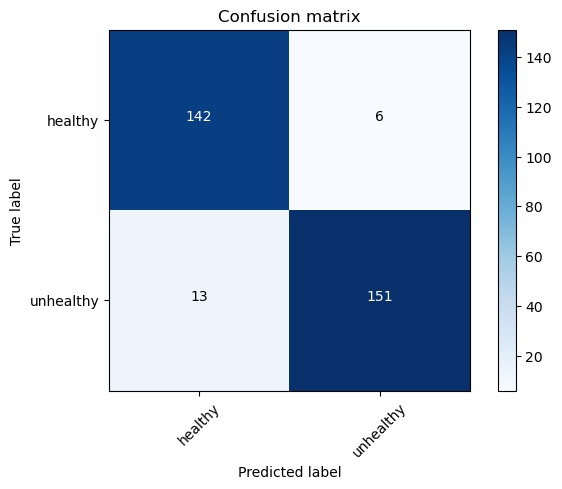

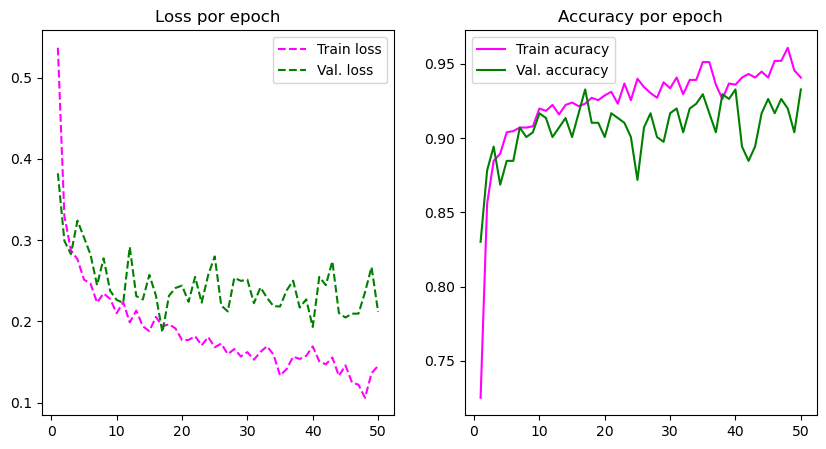

FOLD 2, Model: vgg
Epoch 0/49
----------
Train Loss: 0.5743 Acc: 0.6915 (19.6161 seconds)
Val Loss: 0.4118 Acc: 0.8333 (10.4229 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.3559 Acc: 0.8446 (19.7294 seconds)
Val Loss: 0.3373 Acc: 0.8622 (10.1440 seconds)
Time: 60s


Epoch 2/49
----------
Train Loss: 0.2872 Acc: 0.8798 (20.4007 seconds)
Val Loss: 0.2892 Acc: 0.8910 (10.2082 seconds)
Time: 91s


Epoch 3/49
----------
Train Loss: 0.2486 Acc: 0.8998 (19.5866 seconds)
Val Loss: 0.2820 Acc: 0.8782 (9.8042 seconds)
Time: 120s


Epoch 4/49
----------
Train Loss: 0.2534 Acc: 0.8918 (20.4226 seconds)
Val Loss: 0.2621 Acc: 0.8942 (10.3698 seconds)
Time: 151s


Epoch 5/49
----------
Train Loss: 0.2536 Acc: 0.9030 (20.6717 seconds)
Val Loss: 0.2117 Acc: 0.9167 (9.8774 seconds)
Time: 181s


Epoch 6/49
----------
Train Loss: 0.2722 Acc: 0.8782 (20.1304 seconds)
Val Loss: 0.2220 Acc: 0.9231 (9.9365 seconds)
Time: 211s


Epoch 7/49
----------
Train Loss: 0.2307 Acc: 0.9038 (19.4192 seconds)

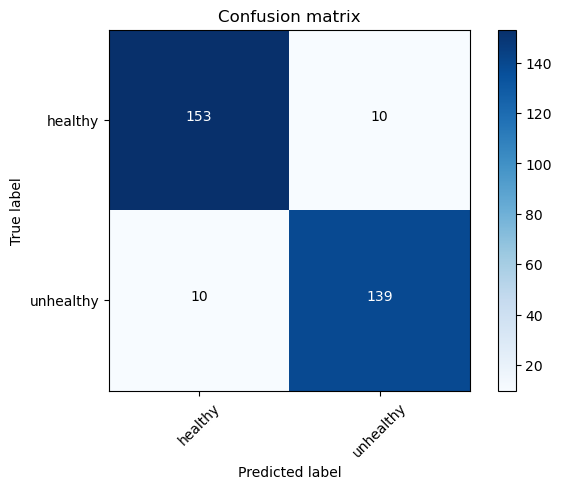

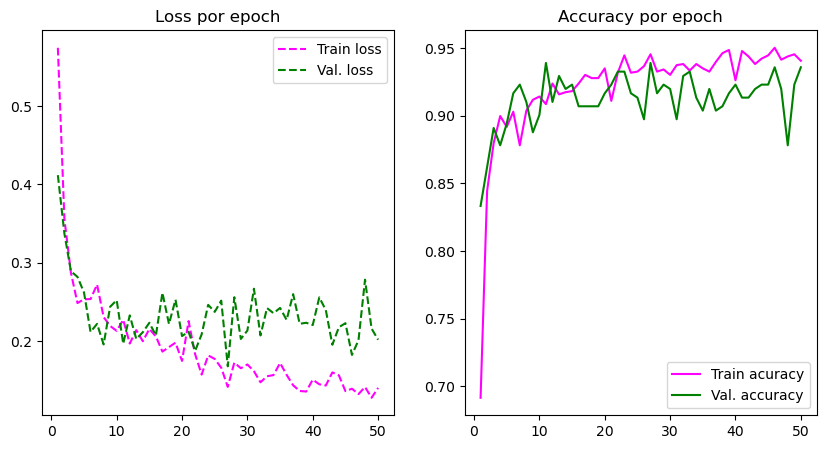

FOLD 3, Model: vgg
Epoch 0/49
----------
Train Loss: 0.5399 Acc: 0.7027 (19.9939 seconds)
Val Loss: 0.3835 Acc: 0.8269 (9.7518 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.3518 Acc: 0.8405 (20.3223 seconds)
Val Loss: 0.3255 Acc: 0.8526 (9.9581 seconds)
Time: 60s


Epoch 2/49
----------
Train Loss: 0.3015 Acc: 0.8790 (19.9563 seconds)
Val Loss: 0.2579 Acc: 0.8910 (9.9934 seconds)
Time: 90s


Epoch 3/49
----------
Train Loss: 0.2971 Acc: 0.8630 (20.1215 seconds)
Val Loss: 0.2840 Acc: 0.8718 (9.7765 seconds)
Time: 120s


Epoch 4/49
----------
Train Loss: 0.2505 Acc: 0.8990 (20.3637 seconds)
Val Loss: 0.2776 Acc: 0.8910 (10.1553 seconds)
Time: 150s


Epoch 5/49
----------
Train Loss: 0.2376 Acc: 0.9159 (19.9949 seconds)
Val Loss: 0.2374 Acc: 0.9103 (9.7809 seconds)
Time: 180s


Epoch 6/49
----------
Train Loss: 0.2436 Acc: 0.8998 (19.9449 seconds)
Val Loss: 0.2818 Acc: 0.8942 (9.8589 seconds)
Time: 210s


Epoch 7/49
----------
Train Loss: 0.2199 Acc: 0.9223 (20.0772 seconds)
Va

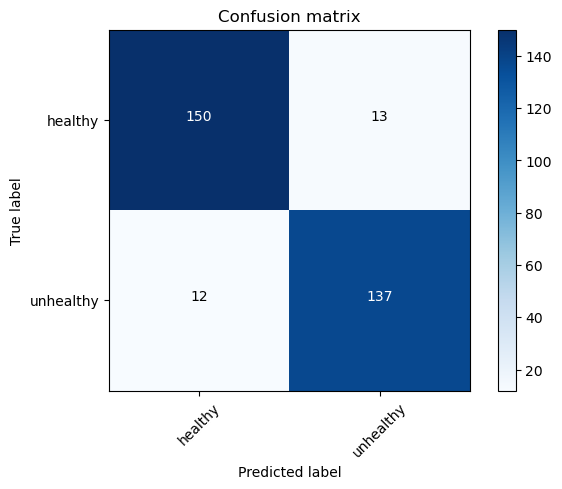

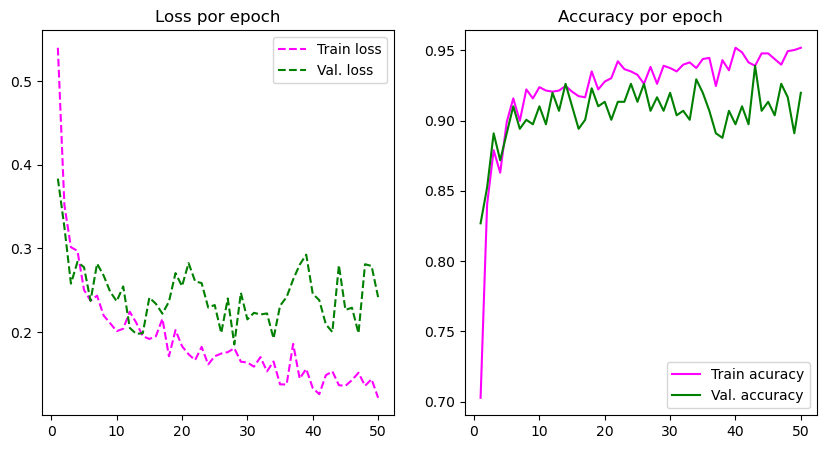

FOLD 4, Model: vgg
Epoch 0/49
----------
Train Loss: 0.5716 Acc: 0.6955 (19.6036 seconds)
Val Loss: 0.3735 Acc: 0.8558 (9.8457 seconds)
Time: 29s


Epoch 1/49
----------
Train Loss: 0.3646 Acc: 0.8454 (19.4939 seconds)
Val Loss: 0.2629 Acc: 0.8974 (10.2986 seconds)
Time: 59s


Epoch 2/49
----------
Train Loss: 0.2871 Acc: 0.8862 (20.8238 seconds)
Val Loss: 0.2192 Acc: 0.9167 (10.2353 seconds)
Time: 90s


Epoch 3/49
----------
Train Loss: 0.2641 Acc: 0.8894 (21.2860 seconds)
Val Loss: 0.2453 Acc: 0.8974 (10.2675 seconds)
Time: 122s


Epoch 4/49
----------
Train Loss: 0.2580 Acc: 0.8990 (20.4114 seconds)
Val Loss: 0.2147 Acc: 0.9135 (10.3157 seconds)
Time: 153s


Epoch 5/49
----------
Train Loss: 0.2804 Acc: 0.8774 (20.2719 seconds)
Val Loss: 0.1648 Acc: 0.9391 (9.9498 seconds)
Time: 183s


Epoch 6/49
----------
Train Loss: 0.2480 Acc: 0.9054 (19.7805 seconds)
Val Loss: 0.2516 Acc: 0.8974 (10.2954 seconds)
Time: 213s


Epoch 7/49
----------
Train Loss: 0.2169 Acc: 0.9111 (20.5034 seconds

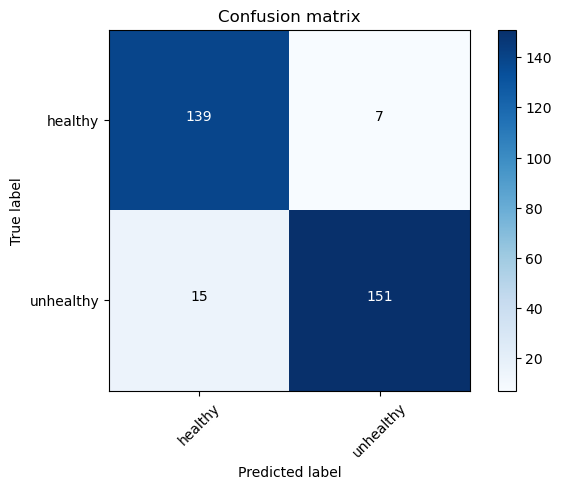

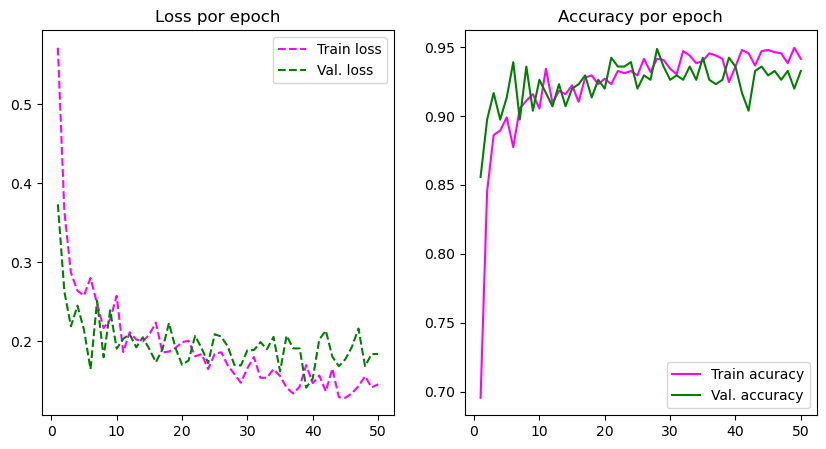

FOLD 0, Model: squeezenet
Epoch 0/49
----------
Train Loss: 0.5428 Acc: 0.7011 (21.2855 seconds)
Val Loss: 0.3867 Acc: 0.8141 (10.6588 seconds)
Time: 32s


Epoch 1/49
----------
Train Loss: 0.3794 Acc: 0.8325 (20.2419 seconds)
Val Loss: 0.3409 Acc: 0.8654 (10.2835 seconds)
Time: 62s


Epoch 2/49
----------
Train Loss: 0.3295 Acc: 0.8638 (20.9497 seconds)
Val Loss: 0.4047 Acc: 0.8590 (10.2512 seconds)
Time: 94s


Epoch 3/49
----------
Train Loss: 0.3205 Acc: 0.8742 (20.8038 seconds)
Val Loss: 0.2723 Acc: 0.9038 (10.2239 seconds)
Time: 125s


Epoch 4/49
----------
Train Loss: 0.2904 Acc: 0.8846 (20.9912 seconds)
Val Loss: 0.3459 Acc: 0.8974 (10.2262 seconds)
Time: 156s


Epoch 5/49
----------
Train Loss: 0.3113 Acc: 0.8894 (21.2302 seconds)
Val Loss: 0.3890 Acc: 0.8878 (10.4006 seconds)
Time: 188s


Epoch 6/49
----------
Train Loss: 0.2737 Acc: 0.8974 (21.2770 seconds)
Val Loss: 0.2729 Acc: 0.9231 (10.3030 seconds)
Time: 219s


Epoch 7/49
----------
Train Loss: 0.2659 Acc: 0.8918 (21.174

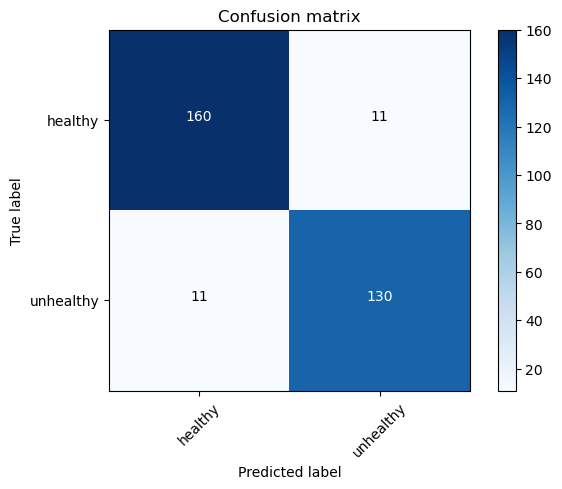

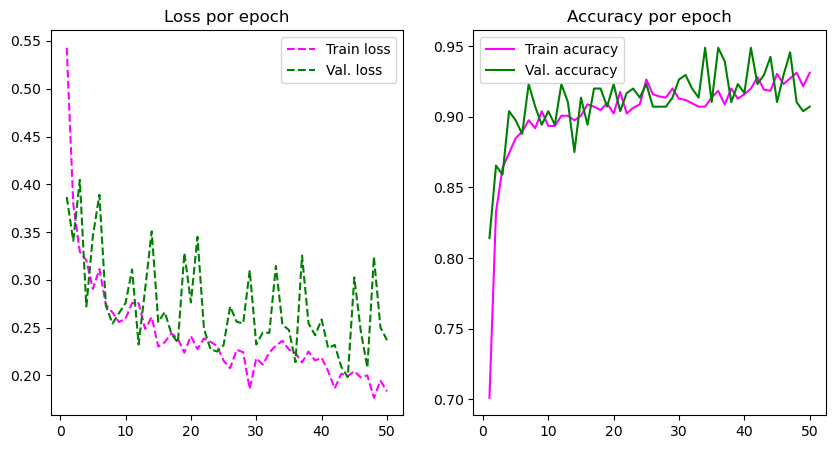

FOLD 1, Model: squeezenet
Epoch 0/49
----------
Train Loss: 0.5262 Acc: 0.7284 (20.2720 seconds)
Val Loss: 0.3429 Acc: 0.8750 (10.3123 seconds)
Time: 31s


Epoch 1/49
----------
Train Loss: 0.3341 Acc: 0.8630 (20.0276 seconds)
Val Loss: 0.3720 Acc: 0.8590 (10.8622 seconds)
Time: 61s


Epoch 2/49
----------
Train Loss: 0.2914 Acc: 0.8870 (20.7685 seconds)
Val Loss: 0.2870 Acc: 0.8782 (10.8756 seconds)
Time: 93s


Epoch 3/49
----------
Train Loss: 0.2857 Acc: 0.8958 (19.6263 seconds)
Val Loss: 0.3291 Acc: 0.8622 (10.5409 seconds)
Time: 123s


Epoch 4/49
----------
Train Loss: 0.3008 Acc: 0.8790 (19.6462 seconds)
Val Loss: 0.4434 Acc: 0.8013 (10.8486 seconds)
Time: 154s


Epoch 5/49
----------
Train Loss: 0.2926 Acc: 0.8846 (21.0563 seconds)
Val Loss: 0.2862 Acc: 0.8782 (11.0112 seconds)
Time: 186s


Epoch 6/49
----------
Train Loss: 0.2839 Acc: 0.8918 (20.6628 seconds)
Val Loss: 0.3172 Acc: 0.8846 (10.7013 seconds)
Time: 217s


Epoch 7/49
----------
Train Loss: 0.2674 Acc: 0.9054 (20.652

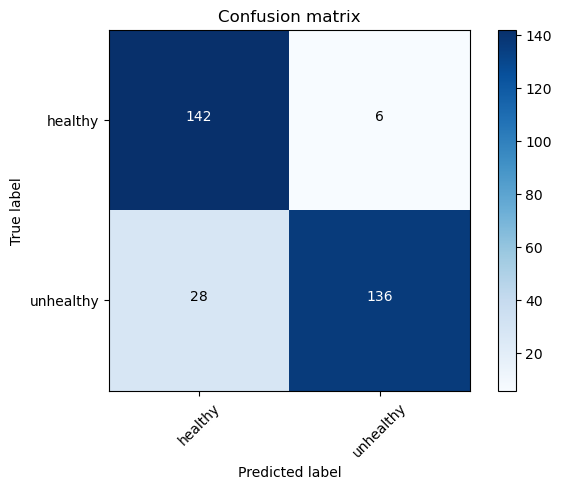

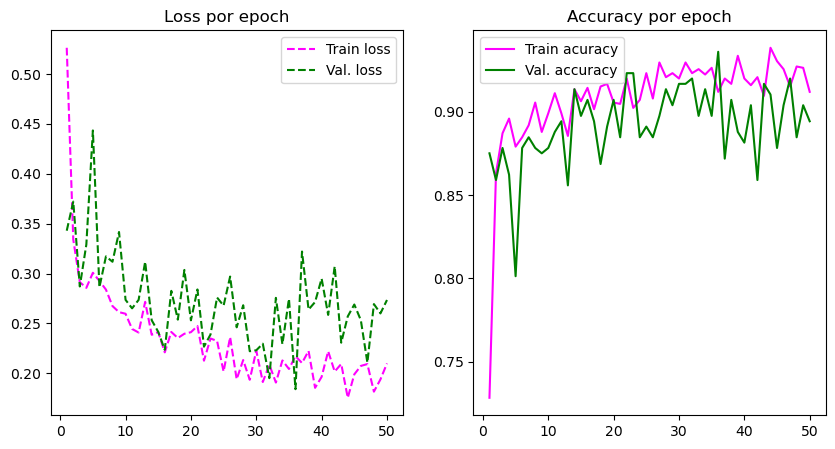

FOLD 2, Model: squeezenet
Epoch 0/49
----------
Train Loss: 0.6008 Acc: 0.6474 (20.5214 seconds)
Val Loss: 0.4965 Acc: 0.7179 (10.2276 seconds)
Time: 31s


Epoch 1/49
----------
Train Loss: 0.3750 Acc: 0.8333 (20.0064 seconds)
Val Loss: 0.3006 Acc: 0.9038 (9.8527 seconds)
Time: 61s


Epoch 2/49
----------
Train Loss: 0.3205 Acc: 0.8774 (20.0780 seconds)
Val Loss: 0.3362 Acc: 0.8718 (10.3474 seconds)
Time: 91s


Epoch 3/49
----------
Train Loss: 0.2728 Acc: 0.8806 (20.2772 seconds)
Val Loss: 0.2660 Acc: 0.9006 (10.6277 seconds)
Time: 122s


Epoch 4/49
----------
Train Loss: 0.3328 Acc: 0.8630 (19.6104 seconds)
Val Loss: 0.3432 Acc: 0.8814 (9.9488 seconds)
Time: 152s


Epoch 5/49
----------
Train Loss: 0.2973 Acc: 0.8958 (20.3400 seconds)
Val Loss: 0.2672 Acc: 0.8974 (9.8843 seconds)
Time: 182s


Epoch 6/49
----------
Train Loss: 0.2255 Acc: 0.9111 (19.9736 seconds)
Val Loss: 0.2681 Acc: 0.9038 (10.1086 seconds)
Time: 212s


Epoch 7/49
----------
Train Loss: 0.2609 Acc: 0.9022 (20.8174 s

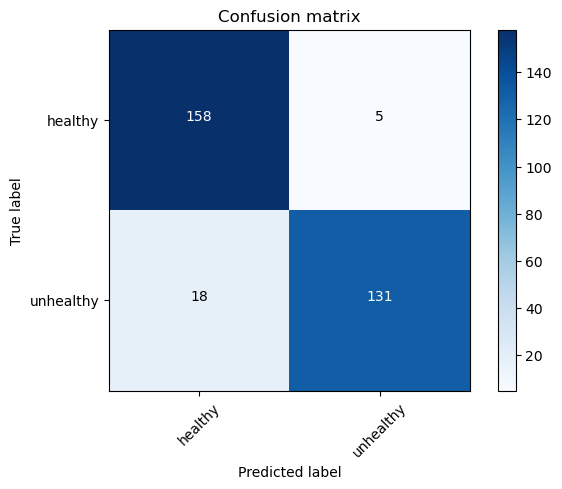

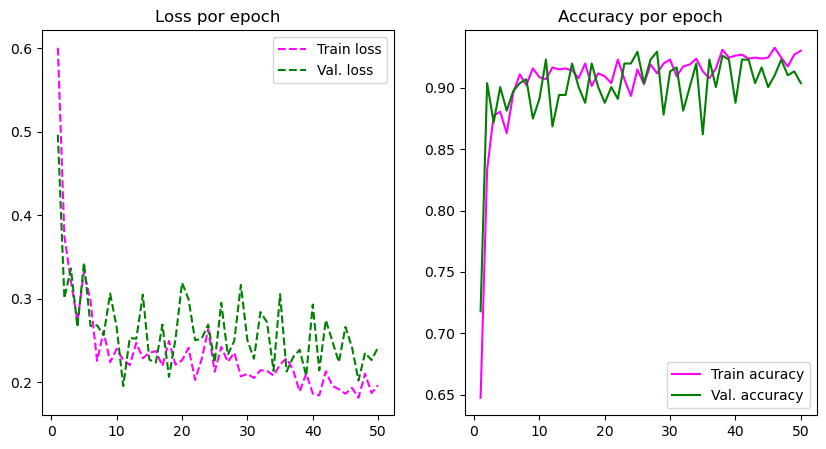

FOLD 3, Model: squeezenet
Epoch 0/49
----------
Train Loss: 0.5840 Acc: 0.6763 (22.3738 seconds)
Val Loss: 0.4421 Acc: 0.7885 (10.2858 seconds)
Time: 33s


Epoch 1/49
----------
Train Loss: 0.4122 Acc: 0.8333 (21.9900 seconds)
Val Loss: 0.4488 Acc: 0.7853 (10.2685 seconds)
Time: 65s


Epoch 2/49
----------
Train Loss: 0.3320 Acc: 0.8542 (21.9234 seconds)
Val Loss: 0.2917 Acc: 0.8910 (10.5139 seconds)
Time: 97s


Epoch 3/49
----------
Train Loss: 0.2745 Acc: 0.8934 (21.1934 seconds)
Val Loss: 0.2893 Acc: 0.8782 (10.4405 seconds)
Time: 129s


Epoch 4/49
----------
Train Loss: 0.2662 Acc: 0.9006 (20.5619 seconds)
Val Loss: 0.3616 Acc: 0.8558 (9.9642 seconds)
Time: 160s


Epoch 5/49
----------
Train Loss: 0.3018 Acc: 0.8806 (21.4069 seconds)
Val Loss: 0.2950 Acc: 0.8718 (9.9672 seconds)
Time: 191s


Epoch 6/49
----------
Train Loss: 0.3019 Acc: 0.8942 (20.7669 seconds)
Val Loss: 0.3213 Acc: 0.8462 (9.9435 seconds)
Time: 222s


Epoch 7/49
----------
Train Loss: 0.2735 Acc: 0.8870 (21.0137 s

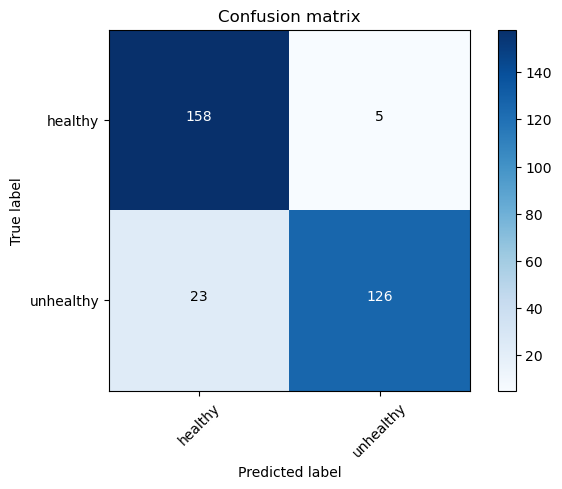

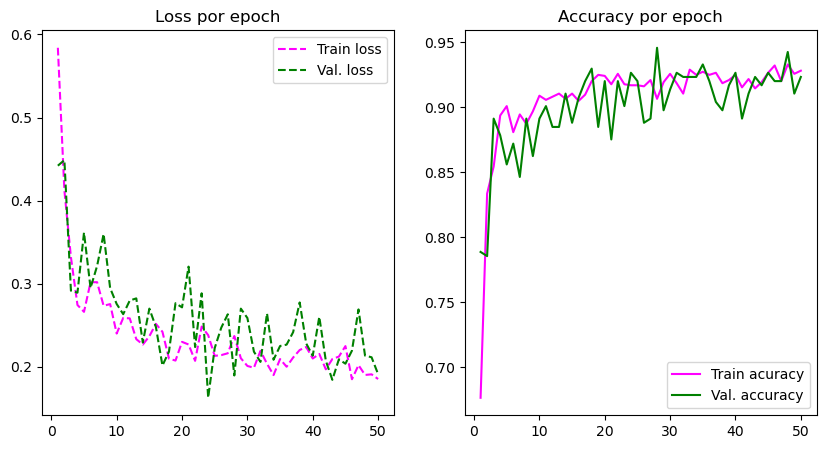

FOLD 4, Model: squeezenet
Epoch 0/49
----------
Train Loss: 0.5585 Acc: 0.7067 (19.7541 seconds)
Val Loss: 0.3459 Acc: 0.8558 (10.3881 seconds)
Time: 30s


Epoch 1/49
----------
Train Loss: 0.3724 Acc: 0.8405 (20.5006 seconds)
Val Loss: 0.2785 Acc: 0.8846 (10.1229 seconds)
Time: 61s


Epoch 2/49
----------
Train Loss: 0.3110 Acc: 0.8686 (21.4327 seconds)
Val Loss: 0.2572 Acc: 0.9006 (10.2739 seconds)
Time: 92s


Epoch 3/49
----------
Train Loss: 0.3152 Acc: 0.8790 (21.6256 seconds)
Val Loss: 0.2683 Acc: 0.8974 (9.9283 seconds)
Time: 124s


Epoch 4/49
----------
Train Loss: 0.2893 Acc: 0.8846 (21.0810 seconds)
Val Loss: 0.2591 Acc: 0.8654 (10.1765 seconds)
Time: 155s


Epoch 5/49
----------
Train Loss: 0.2815 Acc: 0.8926 (21.0720 seconds)
Val Loss: 0.2247 Acc: 0.9199 (10.7734 seconds)
Time: 187s


Epoch 6/49
----------
Train Loss: 0.2646 Acc: 0.8894 (21.0453 seconds)
Val Loss: 0.2204 Acc: 0.9071 (9.8752 seconds)
Time: 218s


Epoch 7/49
----------
Train Loss: 0.2573 Acc: 0.9095 (21.1883 

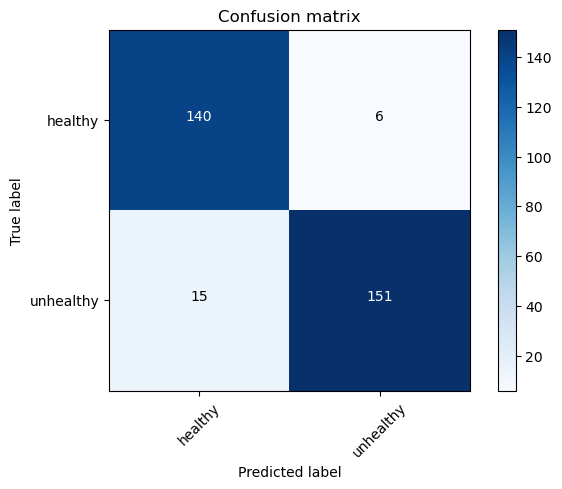

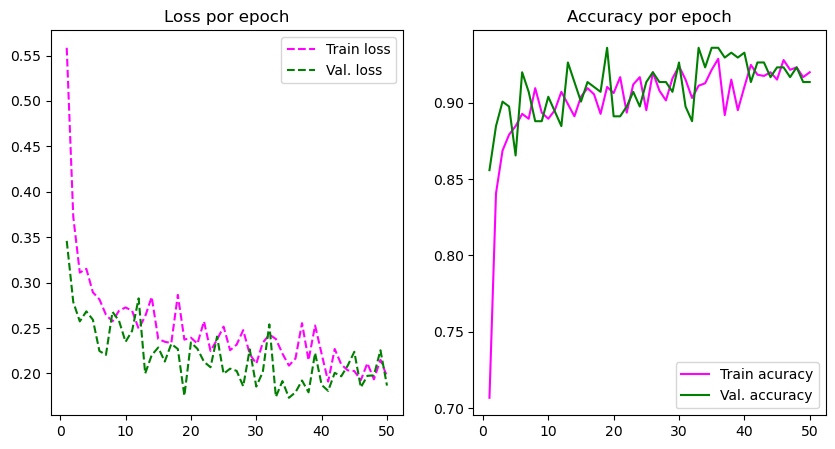

FOLD 0, Model: densenet
Epoch 0/49
----------
Train Loss: 0.5591 Acc: 0.7115 (22.4469 seconds)
Val Loss: 0.4192 Acc: 0.8045 (11.7701 seconds)
Time: 34s


Epoch 1/49
----------
Train Loss: 0.3580 Acc: 0.8550 (21.6975 seconds)
Val Loss: 0.2610 Acc: 0.9038 (10.1958 seconds)
Time: 66s


Epoch 2/49
----------
Train Loss: 0.2668 Acc: 0.8878 (22.3440 seconds)
Val Loss: 0.2374 Acc: 0.9135 (10.2104 seconds)
Time: 99s


Epoch 3/49
----------
Train Loss: 0.2574 Acc: 0.8886 (21.4159 seconds)
Val Loss: 0.2573 Acc: 0.8942 (10.6358 seconds)
Time: 131s


Epoch 4/49
----------
Train Loss: 0.2327 Acc: 0.9014 (20.9634 seconds)
Val Loss: 0.2551 Acc: 0.9103 (10.2565 seconds)
Time: 162s


Epoch 5/49
----------
Train Loss: 0.2115 Acc: 0.9127 (21.3583 seconds)
Val Loss: 0.2079 Acc: 0.9295 (10.6994 seconds)
Time: 194s


Epoch 6/49
----------
Train Loss: 0.2323 Acc: 0.9071 (21.4909 seconds)
Val Loss: 0.2001 Acc: 0.9327 (10.5160 seconds)
Time: 226s


Epoch 7/49
----------
Train Loss: 0.2259 Acc: 0.9119 (19.9631 

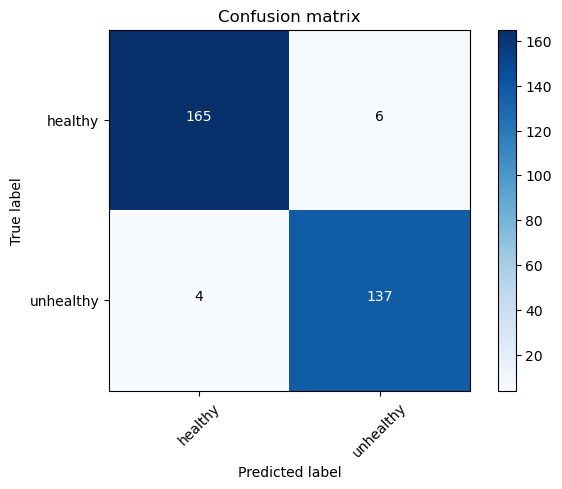

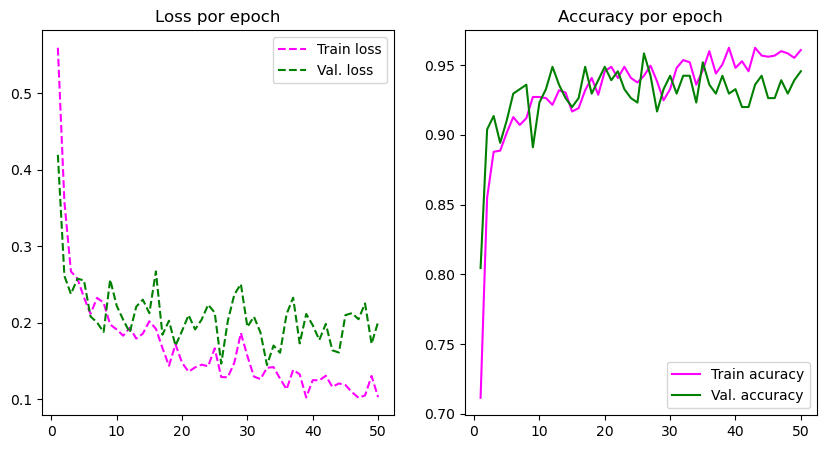

FOLD 1, Model: densenet
Epoch 0/49
----------
Train Loss: 0.5346 Acc: 0.7308 (20.0738 seconds)
Val Loss: 0.3735 Acc: 0.8494 (11.0346 seconds)
Time: 31s


Epoch 1/49
----------
Train Loss: 0.3495 Acc: 0.8454 (20.1487 seconds)
Val Loss: 0.3205 Acc: 0.8878 (10.4204 seconds)
Time: 62s


Epoch 2/49
----------
Train Loss: 0.2758 Acc: 0.8742 (20.2530 seconds)
Val Loss: 0.2879 Acc: 0.8878 (10.1210 seconds)
Time: 92s


Epoch 3/49
----------
Train Loss: 0.2558 Acc: 0.8998 (20.6341 seconds)
Val Loss: 0.2747 Acc: 0.8782 (10.3383 seconds)
Time: 123s


Epoch 4/49
----------
Train Loss: 0.2385 Acc: 0.9087 (18.6273 seconds)
Val Loss: 0.2652 Acc: 0.8782 (10.8386 seconds)
Time: 153s


Epoch 5/49
----------
Train Loss: 0.2133 Acc: 0.9103 (19.4636 seconds)
Val Loss: 0.2873 Acc: 0.8910 (10.9357 seconds)
Time: 183s


Epoch 6/49
----------
Train Loss: 0.2166 Acc: 0.9207 (20.3184 seconds)
Val Loss: 0.2125 Acc: 0.9199 (10.5302 seconds)
Time: 214s


Epoch 7/49
----------
Train Loss: 0.2100 Acc: 0.9231 (20.3439 

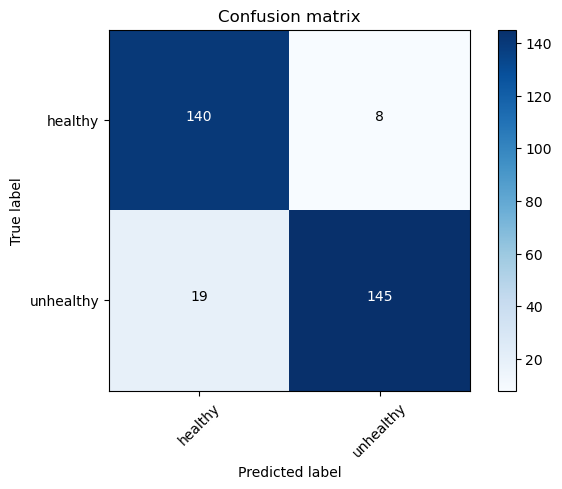

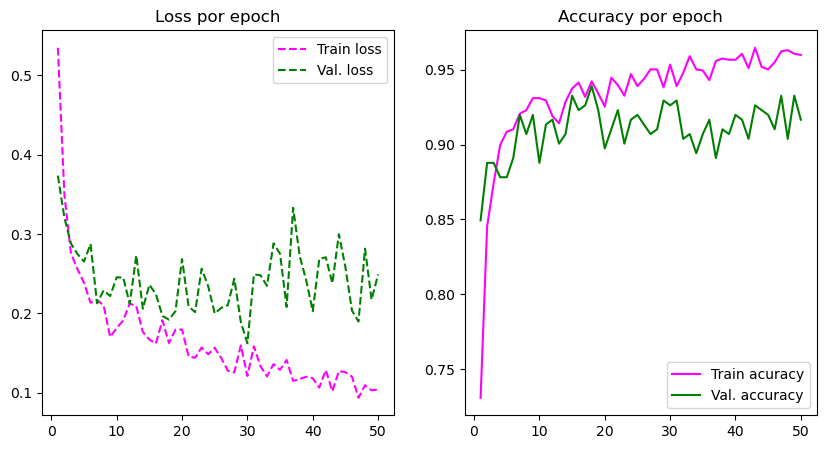

FOLD 2, Model: densenet
Epoch 0/49
----------
Train Loss: 0.5593 Acc: 0.7019 (19.4216 seconds)
Val Loss: 0.3818 Acc: 0.8365 (9.5915 seconds)
Time: 29s


Epoch 1/49
----------
Train Loss: 0.3638 Acc: 0.8421 (21.1876 seconds)
Val Loss: 0.2877 Acc: 0.8814 (10.1196 seconds)
Time: 60s


Epoch 2/49
----------
Train Loss: 0.2809 Acc: 0.8878 (20.7628 seconds)
Val Loss: 0.2950 Acc: 0.8878 (10.0256 seconds)
Time: 91s


Epoch 3/49
----------
Train Loss: 0.2689 Acc: 0.8958 (19.9224 seconds)
Val Loss: 0.2284 Acc: 0.9167 (10.1510 seconds)
Time: 121s


Epoch 4/49
----------
Train Loss: 0.2229 Acc: 0.9167 (20.8650 seconds)
Val Loss: 0.2276 Acc: 0.9231 (9.8840 seconds)
Time: 152s


Epoch 5/49
----------
Train Loss: 0.2403 Acc: 0.9062 (21.0348 seconds)
Val Loss: 0.2211 Acc: 0.9199 (10.4494 seconds)
Time: 184s


Epoch 6/49
----------
Train Loss: 0.2295 Acc: 0.9071 (19.9310 seconds)
Val Loss: 0.2297 Acc: 0.9167 (10.1874 seconds)
Time: 214s


Epoch 7/49
----------
Train Loss: 0.2072 Acc: 0.9143 (21.5117 se

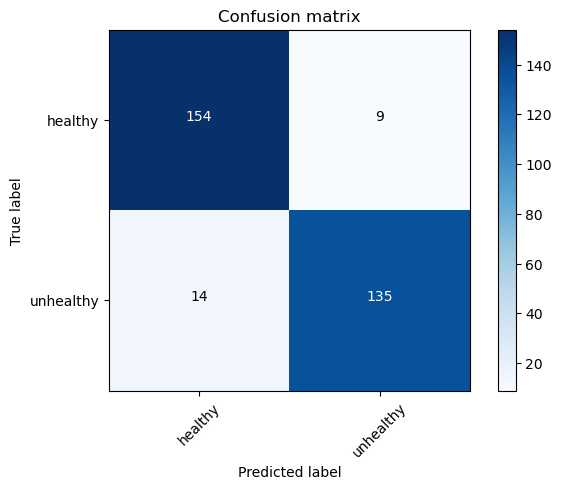

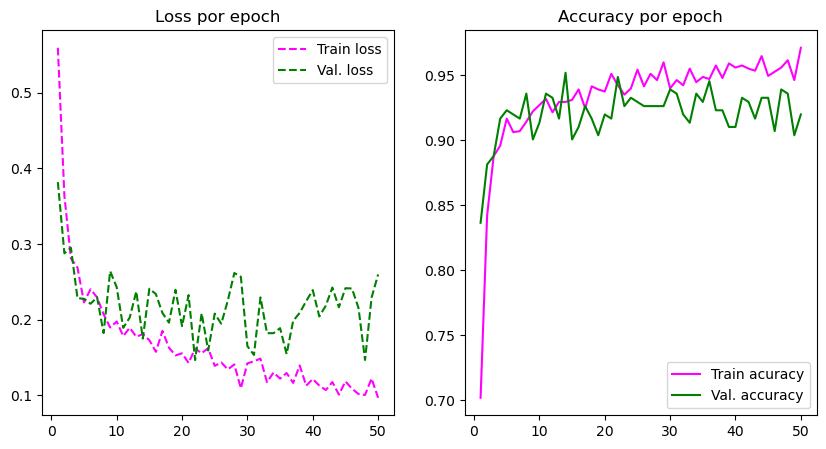

FOLD 3, Model: densenet
Epoch 0/49
----------
Train Loss: 0.5601 Acc: 0.7228 (20.8957 seconds)
Val Loss: 0.4048 Acc: 0.8109 (9.8364 seconds)
Time: 31s


Epoch 1/49
----------
Train Loss: 0.3370 Acc: 0.8542 (20.8538 seconds)
Val Loss: 0.3162 Acc: 0.8590 (9.7580 seconds)
Time: 61s


Epoch 2/49
----------
Train Loss: 0.2494 Acc: 0.8990 (20.4552 seconds)
Val Loss: 0.2664 Acc: 0.8878 (9.8070 seconds)
Time: 92s


Epoch 3/49
----------
Train Loss: 0.2626 Acc: 0.8942 (20.5587 seconds)
Val Loss: 0.2632 Acc: 0.8910 (9.8965 seconds)
Time: 122s


Epoch 4/49
----------
Train Loss: 0.2449 Acc: 0.8926 (19.7409 seconds)
Val Loss: 0.2456 Acc: 0.8974 (9.7678 seconds)
Time: 152s


Epoch 5/49
----------
Train Loss: 0.2625 Acc: 0.8982 (20.5146 seconds)
Val Loss: 0.2236 Acc: 0.9038 (9.7767 seconds)
Time: 182s


Epoch 6/49
----------
Train Loss: 0.2366 Acc: 0.9095 (20.9228 seconds)
Val Loss: 0.2699 Acc: 0.9038 (9.9287 seconds)
Time: 213s


Epoch 7/49
----------
Train Loss: 0.2117 Acc: 0.9151 (20.7478 seconds

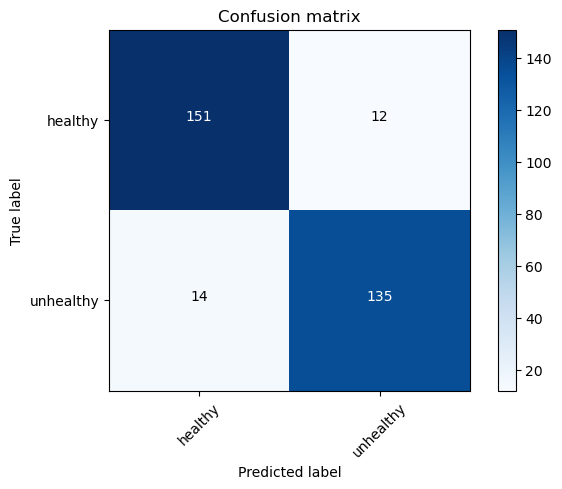

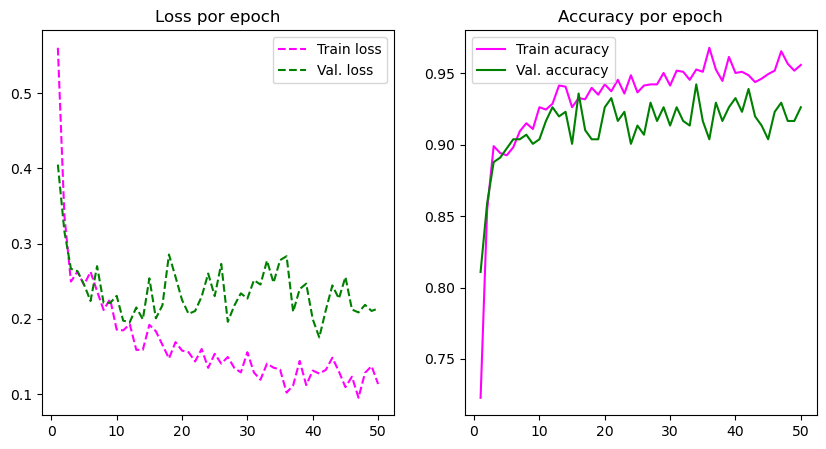

FOLD 4, Model: densenet
Epoch 0/49
----------
Train Loss: 0.5483 Acc: 0.7228 (21.8626 seconds)
Val Loss: 0.3425 Acc: 0.8526 (10.6507 seconds)
Time: 33s


Epoch 1/49
----------
Train Loss: 0.3371 Acc: 0.8574 (21.4918 seconds)
Val Loss: 0.2459 Acc: 0.8942 (10.5344 seconds)
Time: 65s


Epoch 2/49
----------
Train Loss: 0.2859 Acc: 0.8830 (20.0695 seconds)
Val Loss: 0.2740 Acc: 0.8782 (10.0166 seconds)
Time: 95s


Epoch 3/49
----------
Train Loss: 0.2570 Acc: 0.9046 (21.5143 seconds)
Val Loss: 0.2581 Acc: 0.8942 (10.3709 seconds)
Time: 127s


Epoch 4/49
----------
Train Loss: 0.2309 Acc: 0.9127 (21.1228 seconds)
Val Loss: 0.2089 Acc: 0.9199 (11.5319 seconds)
Time: 159s


Epoch 5/49
----------
Train Loss: 0.2256 Acc: 0.9135 (20.5588 seconds)
Val Loss: 0.1809 Acc: 0.9199 (10.3806 seconds)
Time: 190s


Epoch 6/49
----------
Train Loss: 0.2144 Acc: 0.9159 (20.7626 seconds)
Val Loss: 0.2081 Acc: 0.9071 (9.7490 seconds)
Time: 221s


Epoch 7/49
----------
Train Loss: 0.2066 Acc: 0.9103 (20.1137 s

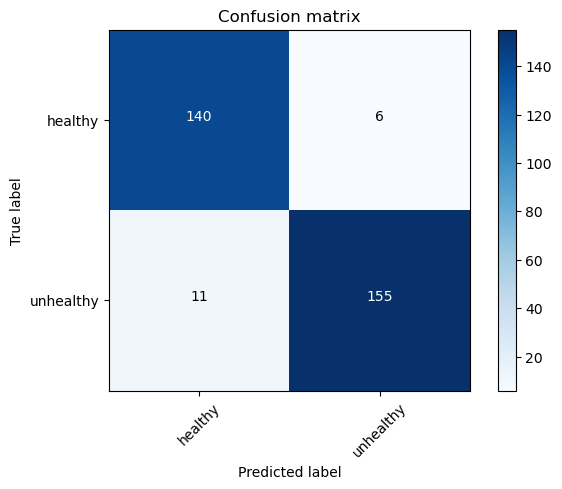

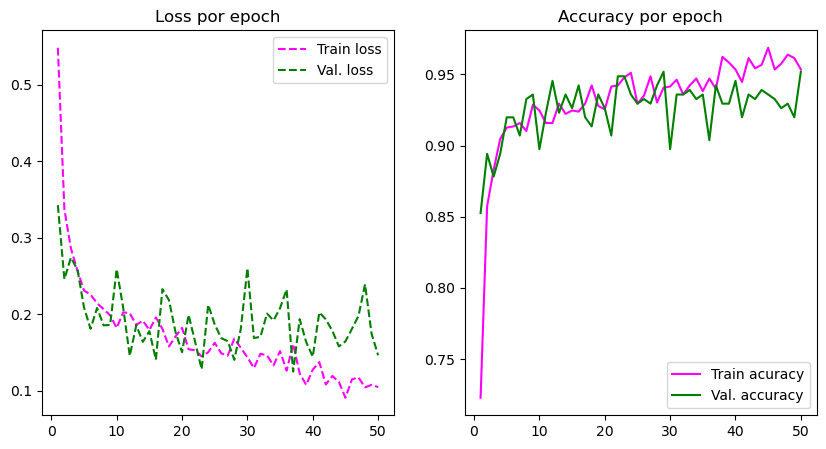

FOLD 0, Model: inception
Epoch 0/49
----------
Train Loss: 0.8848 Acc: 0.6186 (24.8296 seconds)
Val Loss: 0.5336 Acc: 0.8013 (11.7586 seconds)
Time: 37s


Epoch 1/49
----------
Train Loss: 0.6252 Acc: 0.8069 (20.9322 seconds)
Val Loss: 0.3638 Acc: 0.8526 (10.3264 seconds)
Time: 68s


Epoch 2/49
----------
Train Loss: 0.4552 Acc: 0.8582 (21.6462 seconds)
Val Loss: 0.3090 Acc: 0.8974 (10.2001 seconds)
Time: 100s


Epoch 3/49
----------
Train Loss: 0.3379 Acc: 0.9022 (21.7868 seconds)
Val Loss: 0.2092 Acc: 0.9295 (10.4130 seconds)
Time: 132s


Epoch 4/49
----------
Train Loss: 0.3529 Acc: 0.9006 (21.5114 seconds)
Val Loss: 0.2241 Acc: 0.9103 (10.1144 seconds)
Time: 164s


Epoch 5/49
----------
Train Loss: 0.3070 Acc: 0.9143 (19.6507 seconds)
Val Loss: 0.2083 Acc: 0.9231 (10.0421 seconds)
Time: 193s


Epoch 6/49
----------
Train Loss: 0.2964 Acc: 0.9167 (20.3560 seconds)
Val Loss: 0.2022 Acc: 0.9295 (10.2300 seconds)
Time: 224s


Epoch 7/49
----------
Train Loss: 0.2877 Acc: 0.9183 (19.992

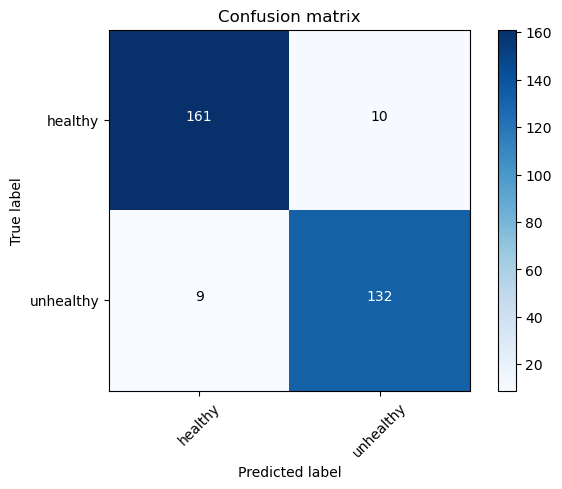

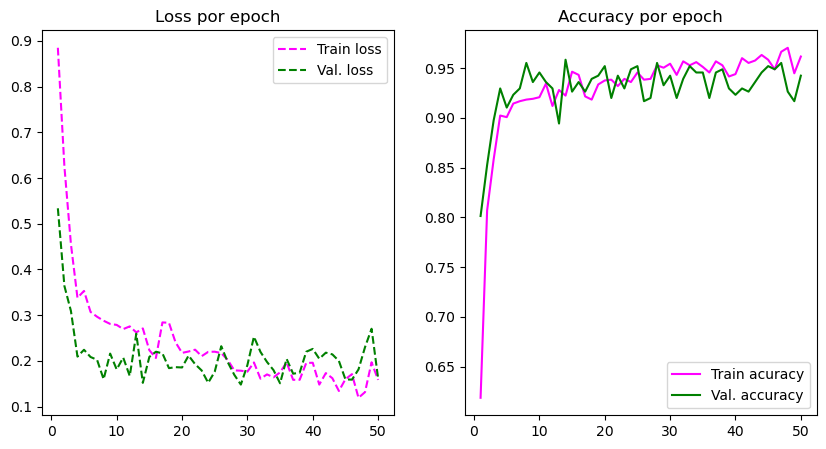

FOLD 1, Model: inception
Epoch 0/49
----------
Train Loss: 0.8908 Acc: 0.6122 (21.4659 seconds)
Val Loss: 0.5477 Acc: 0.7853 (10.7630 seconds)
Time: 32s


Epoch 1/49
----------
Train Loss: 0.6028 Acc: 0.8197 (19.6479 seconds)
Val Loss: 0.3759 Acc: 0.8590 (10.3981 seconds)
Time: 62s


Epoch 2/49
----------
Train Loss: 0.4649 Acc: 0.8614 (20.7174 seconds)
Val Loss: 0.2798 Acc: 0.9103 (10.9211 seconds)
Time: 94s


Epoch 3/49
----------
Train Loss: 0.4023 Acc: 0.8734 (20.3171 seconds)
Val Loss: 0.2941 Acc: 0.8846 (10.3477 seconds)
Time: 125s


Epoch 4/49
----------
Train Loss: 0.3589 Acc: 0.8894 (19.6514 seconds)
Val Loss: 0.2326 Acc: 0.9135 (10.6441 seconds)
Time: 155s


Epoch 5/49
----------
Train Loss: 0.3411 Acc: 0.9022 (20.8567 seconds)
Val Loss: 0.2266 Acc: 0.9167 (10.7537 seconds)
Time: 187s


Epoch 6/49
----------
Train Loss: 0.2876 Acc: 0.9175 (20.7993 seconds)
Val Loss: 0.2426 Acc: 0.9071 (10.7426 seconds)
Time: 218s


Epoch 7/49
----------
Train Loss: 0.2788 Acc: 0.9159 (20.2959

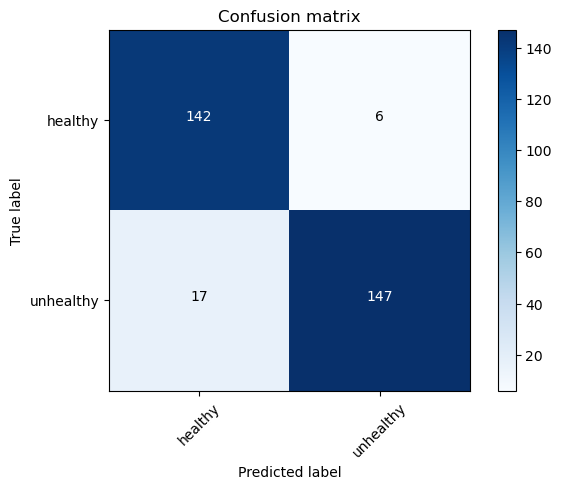

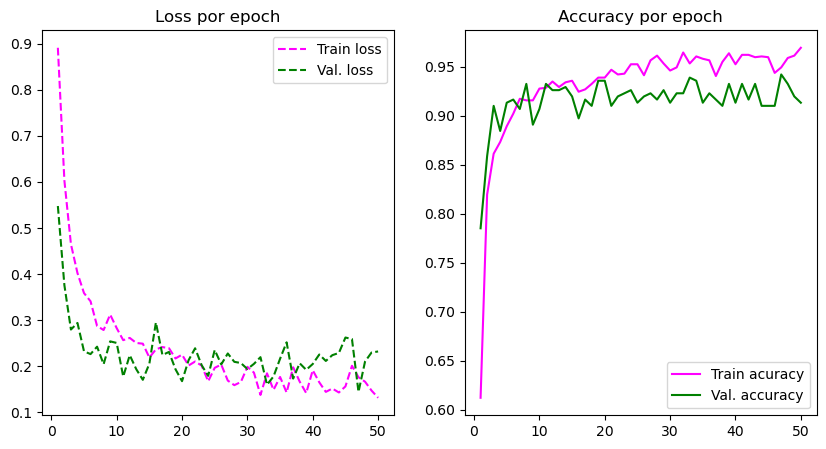

FOLD 2, Model: inception
Epoch 0/49
----------
Train Loss: 0.8903 Acc: 0.5905 (20.6933 seconds)
Val Loss: 0.5326 Acc: 0.8013 (10.2235 seconds)
Time: 31s


Epoch 1/49
----------
Train Loss: 0.6451 Acc: 0.7869 (21.7748 seconds)
Val Loss: 0.3610 Acc: 0.8846 (10.2252 seconds)
Time: 63s


Epoch 2/49
----------
Train Loss: 0.4773 Acc: 0.8558 (21.8811 seconds)
Val Loss: 0.3189 Acc: 0.8590 (10.3765 seconds)
Time: 95s


Epoch 3/49
----------
Train Loss: 0.3900 Acc: 0.8790 (21.9145 seconds)
Val Loss: 0.3050 Acc: 0.8782 (10.4038 seconds)
Time: 128s


Epoch 4/49
----------
Train Loss: 0.3397 Acc: 0.9062 (21.8525 seconds)
Val Loss: 0.2422 Acc: 0.9103 (10.4042 seconds)
Time: 160s


Epoch 5/49
----------
Train Loss: 0.2795 Acc: 0.9263 (22.0350 seconds)
Val Loss: 0.2510 Acc: 0.9071 (10.3015 seconds)
Time: 192s


Epoch 6/49
----------
Train Loss: 0.3618 Acc: 0.9030 (21.2270 seconds)
Val Loss: 0.2064 Acc: 0.9135 (10.2304 seconds)
Time: 224s


Epoch 7/49
----------
Train Loss: 0.3005 Acc: 0.9183 (21.2136

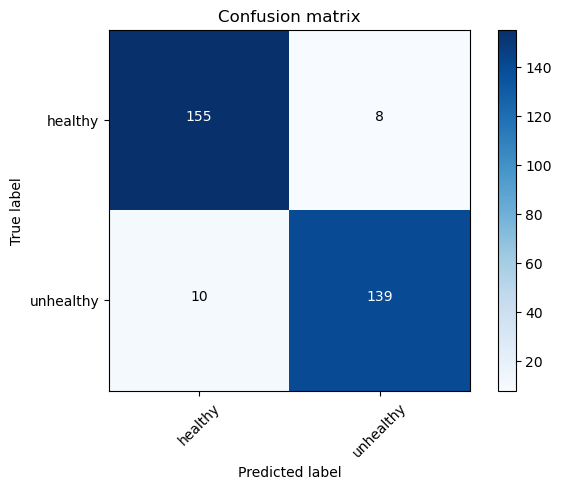

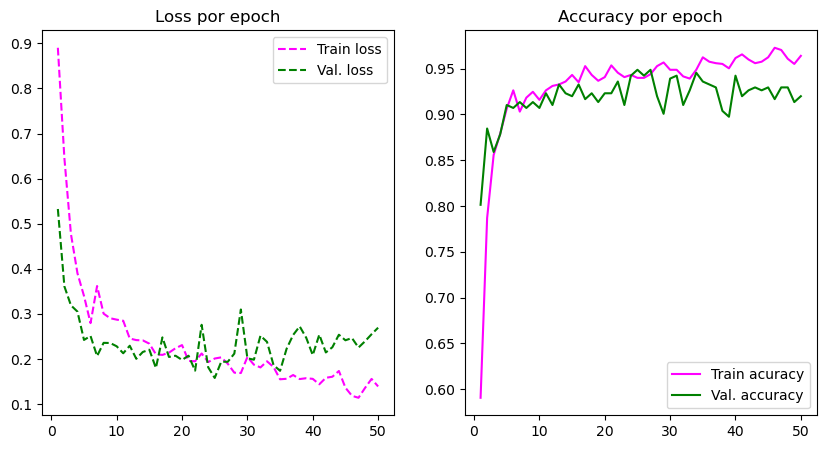

FOLD 3, Model: inception
Epoch 0/49
----------
Train Loss: 0.8562 Acc: 0.6378 (21.0317 seconds)
Val Loss: 0.5349 Acc: 0.7853 (10.0332 seconds)
Time: 31s


Epoch 1/49
----------
Train Loss: 0.6131 Acc: 0.8005 (20.9016 seconds)
Val Loss: 0.4113 Acc: 0.8397 (10.3207 seconds)
Time: 62s


Epoch 2/49
----------
Train Loss: 0.4561 Acc: 0.8550 (22.0182 seconds)
Val Loss: 0.3114 Acc: 0.8590 (10.4803 seconds)
Time: 95s


Epoch 3/49
----------
Train Loss: 0.3926 Acc: 0.8894 (22.0431 seconds)
Val Loss: 0.2775 Acc: 0.8878 (9.8506 seconds)
Time: 127s


Epoch 4/49
----------
Train Loss: 0.3592 Acc: 0.8870 (21.9739 seconds)
Val Loss: 0.2176 Acc: 0.9135 (10.2024 seconds)
Time: 159s


Epoch 5/49
----------
Train Loss: 0.3475 Acc: 0.8958 (22.2978 seconds)
Val Loss: 0.2119 Acc: 0.9263 (10.4572 seconds)
Time: 192s


Epoch 6/49
----------
Train Loss: 0.2962 Acc: 0.9191 (20.8747 seconds)
Val Loss: 0.2309 Acc: 0.9199 (10.0117 seconds)
Time: 223s


Epoch 7/49
----------
Train Loss: 0.2664 Acc: 0.9303 (22.2845 

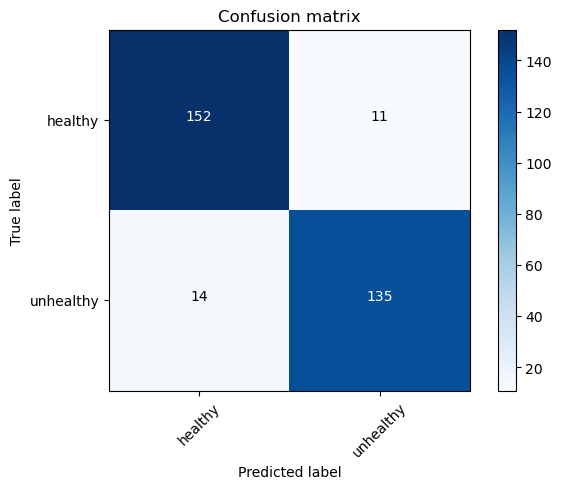

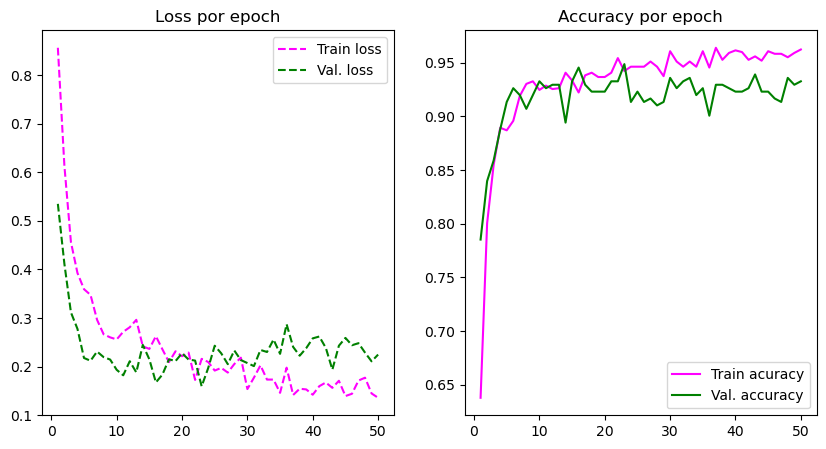

FOLD 4, Model: inception
Epoch 0/49
----------
Train Loss: 0.8702 Acc: 0.6330 (21.8616 seconds)
Val Loss: 0.5087 Acc: 0.7917 (10.3627 seconds)
Time: 32s


Epoch 1/49
----------
Train Loss: 0.6430 Acc: 0.7780 (22.0482 seconds)
Val Loss: 0.3628 Acc: 0.8301 (10.6605 seconds)
Time: 65s


Epoch 2/49
----------
Train Loss: 0.4819 Acc: 0.8494 (21.3073 seconds)
Val Loss: 0.3090 Acc: 0.8526 (10.1423 seconds)
Time: 97s


Epoch 3/49
----------
Train Loss: 0.3502 Acc: 0.8950 (21.7224 seconds)
Val Loss: 0.2288 Acc: 0.9199 (10.5227 seconds)
Time: 129s


Epoch 4/49
----------
Train Loss: 0.3584 Acc: 0.8998 (22.1482 seconds)
Val Loss: 0.2109 Acc: 0.9167 (10.5763 seconds)
Time: 162s


Epoch 5/49
----------
Train Loss: 0.3570 Acc: 0.8950 (21.9164 seconds)
Val Loss: 0.2166 Acc: 0.9231 (10.5414 seconds)
Time: 194s


Epoch 6/49
----------
Train Loss: 0.3023 Acc: 0.9143 (21.7070 seconds)
Val Loss: 0.1884 Acc: 0.9103 (10.7062 seconds)
Time: 226s


Epoch 7/49
----------
Train Loss: 0.3289 Acc: 0.9135 (20.5018

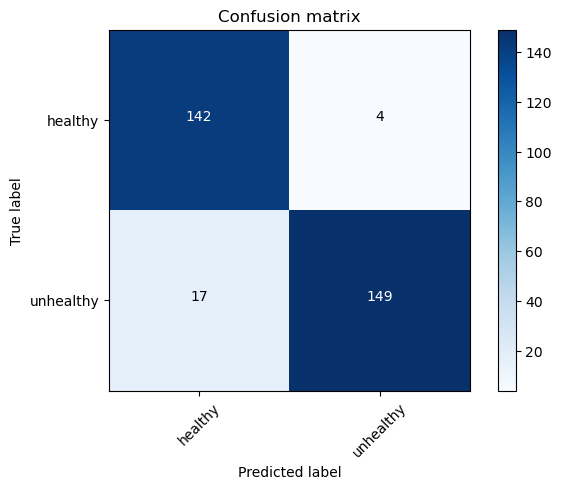

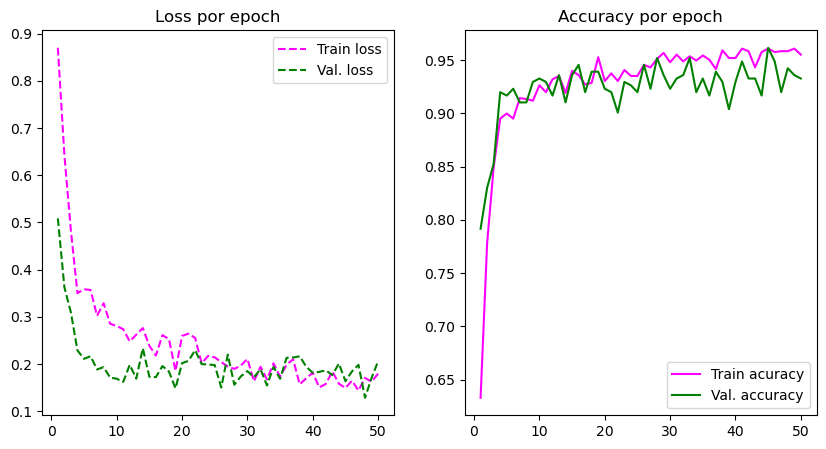

In [8]:
# Verifica se a GPU está disponível
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print('\nDevice: {0}'.format(device))
# print(torch.cuda.get_device_name(0))
# !nvidia-smi

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# Define o caminho base do diretório de imagens divididas 
base_dir = r'data/RoCole/sorted_binary/'


for model in ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']:
    
    basic_parameters = {
    'num_classes' : 2,
    'class_names': ['healthy', 'unhealthy'],
    'batch_size' : 32,
    'lr' : 0.001, # Taxa de aprendizado
    'mm' : 0.9, # Mommentum
    'epochs' : 50,
    'model_name' : model, # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
    'criterion' : nn.CrossEntropyLoss() # Função de perda
    }

    model_ft, input_size = initialize_model(basic_parameters.get('model_name'), basic_parameters.get('num_classes'))


    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = datasets.ImageFolder(base_dir, data_transforms['train'])

    # # Pretrainned
    # model_ft = model_ft.to(device)  

    date_now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    folds = kf.split(image_datasets)


    for fold, (train_idx, val_idx) in enumerate(folds):
        
        model = basic_parameters.get('model_name')
        print(f'FOLD {fold}, Model: {model}')

        train_dataset = torch.utils.data.Subset(image_datasets, train_idx)
        val_dataset = torch.utils.data.Subset(image_datasets, val_idx)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=basic_parameters.get('batch_size'), shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=basic_parameters.get('batch_size'), shuffle=True, num_workers=4)

        dataloaders_dict = {'train': train_loader, 'val': val_loader}

        # Reiniciar o modelo em cada fold
        model_ft, input_size = initialize_model(basic_parameters.get('model_name'), basic_parameters.get('num_classes'))
        model_ft = model_ft.to(device)
        # Imprime o modelo
        # print(f'Model: {str(model_ft)}')
        
        # Otimizador
        optimizer = optim.SGD(model_ft.parameters(), lr=basic_parameters.get('lr'), momentum=basic_parameters.get('mm'))

        model_ft = train_model(model_ft, dataloaders_dict, optimizer, basic_parameters, fold,date_now, device)
   

In [9]:
# base_dir = 'data\RoCole\sorted_binary'

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio(base_dir, output="splited", seed=42, ratio=(.8, .1, .1)) # default values (.8, .1, .1)
# print("Splits Ok!")

In [10]:
# def show_transformed_image(image):
#     # Unnormalize all channels 
#     ### for t, m, s in zip(np_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#     for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): # (ImageNet weights)       
#         t.mul_(s).add_(m)

#     np_image = image.numpy()

#     plt.figure(figsize=(20, 20))
#     plt.imshow(np.transpose(np_image, (1, 2, 0)))

# # Visualizar 'batch_size' imagens
# dataloader_vis = torch.utils.data.DataLoader(dataset=image_datasets['train'], shuffle=True, batch_size=64)
# items = iter(dataloader_vis)
# image, label = next(items)

# show_transformed_image(utils.make_grid(image))